<h1 style="color:#1f77b4; text-align:left; font-size:40px;">
    Data Preparation
</h1>

<h3 style="color:#555; text-align:left;">
    Handling mIssing values, outliers detection tratment, codification (categrical values), normalization, feature engineering and feature selection
</h3>


<h2 style="color:#1f77b4; border-bottom: 3px solid #1f77b4; padding-bottom:4px;">
</h2>

# **1: Data importation**

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
src_path = project_root / "src"
sys.path.append(str(src_path))

from utils_data import load_df, quick_overview

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

import scipy.stats as stats
from scipy.stats import chi2_contingency # filter method

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE # wrapper method
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import mutual_info_classif

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression #(This is one possible model to apply inside RFE)
from sklearn.linear_model import LassoCV # embedded method

from sklearn.tree import DecisionTreeClassifier # embedded method
from sklearn.ensemble import RandomForestClassifier  # embedded method

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

from sklearn.base import clone
import os



In [2]:
MASTER_NAME = "telco_master_basic_clean"

df = load_df(MASTER_NAME, folder="interim")
print(f"\nLoaded '{MASTER_NAME}' from interim with shape: {df.shape}")

📂 Loaded: C:\Users\sarac\rep_EDSB\EnterpriseDataScienceBootcamp_workgroup\data\interim\telco_master_basic_clean.csv

Loaded 'telco_master_basic_clean' from interim with shape: (7043, 31)


# **2: Data Separation: Hold-Out Method**

In [3]:
target_col = 'st_churn_label'

# Extract target
y = df[target_col].copy()

# Create X by removing only the selected columns (drop-if-exists logic)
X = df.drop(columns=[target_col])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (7043, 30)
y shape: (7043,)


In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}:")
    
    print("X_train: Nº index =", train_index.shape[0])
    print("train_index head(5) =", train_index[:5])
    
    print("X_test: Nº index =", test_index.shape[0])
    print("test_index head(5) =", test_index[:5])
    
    print("-" * 30)

Fold 1:
X_train: Nº index = 5634
train_index head(5) = [0 1 2 4 5]
X_test: Nº index = 1409
test_index head(5) = [ 3  6  7 11 15]
------------------------------
Fold 2:
X_train: Nº index = 5634
train_index head(5) = [0 1 2 3 5]
X_test: Nº index = 1409
test_index head(5) = [ 4  9 10 25 33]
------------------------------
Fold 3:
X_train: Nº index = 5634
train_index head(5) = [0 1 2 3 4]
X_test: Nº index = 1409
test_index head(5) = [ 8 12 14 26 28]
------------------------------
Fold 4:
X_train: Nº index = 5635
train_index head(5) = [0 1 3 4 6]
X_test: Nº index = 1408
test_index head(5) = [ 2  5 13 16 17]
------------------------------
Fold 5:
X_train: Nº index = 5635
train_index head(5) = [2 3 4 5 6]
X_test: Nº index = 1408
test_index head(5) = [ 0  1 21 22 23]
------------------------------


# **3: Data Cleaning**
## **3.1 Handling Missing Values**

In [5]:
#Handle meaningful missing values in categoricals
# Fill missing values with explicit categories where appropriate
fill_map = {}

if "svc_offer" in X.columns:
    fill_map["svc_offer"] = "No Offer"

if "svc_internet_type" in X.columns:
    fill_map["svc_internet_type"] = "No Internet"

X = X.fillna(value=fill_map)

# Quick check
X[["svc_offer", "svc_internet_type"]].head()


,svc_offer,svc_internet_type
0,No Offer,DSL
1,Offer E,Fiber Optic
2,Offer D,Fiber Optic
3,Offer C,Fiber Optic
4,Offer C,Fiber Optic


# **4: Data Transformation**
## **4.1: Creating new variables**
### **4.1.1: variable "Is_woman"**

In [6]:
X["demo_gender"].value_counts(dropna=False)

demo_gender
Male      3555
Female    3488
Name: count, dtype: int64

In [7]:
X["Is_woman"] = X["demo_gender"].map({"Male": 0, "Female": 1})

In [8]:
X["Is_woman"].value_counts(dropna=False)

Is_woman
0    3555
1    3488
Name: count, dtype: int64

### **4.1.2: variable "Has_offer"**

In [9]:
X["svc_offer"].value_counts(dropna=False)

svc_offer
No Offer    3877
Offer B      824
Offer E      805
Offer D      602
Offer A      520
Offer C      415
Name: count, dtype: int64

In [10]:
X["Has_offer"] = X["svc_offer"].map({"No Offer": 0, "Offer A": 1, "Offer B": 1, "Offer C": 1, "Offer D": 1, "Offer E": 1})

In [11]:
X["Has_offer"].value_counts(dropna=False)

Has_offer
0    3877
1    3166
Name: count, dtype: int64

## **4.2: Encoding target variable**

In [12]:
# Convert target Yes/No → 1/0
y = df["st_churn_label"].map({"No": 0, "Yes": 1})


## **4.3: Binning**

In [13]:
binary_cols = [
    "demo_married",
    "svc_referred_a_friend",
    "svc_phone_service",
    "svc_multiple_lines",
    "svc_internet_service",
    "svc_online_security",
    "svc_online_backup",
    "svc_device_protection_plan",
    "svc_premium_tech_support",
    "svc_streaming_tv",
    "svc_streaming_movies",
    "svc_streaming_music",
    "svc_unlimited_data",
    "svc_paperless_billing",
]

# Convert Yes/No → 1/0
for col in binary_cols:
    if col in X.columns:
        X[col] = X[col].map({"Yes": 1, "No": 0})

# Quick check
print("Binary columns converted to 0/1:")
for col in binary_cols:
    if col in X.columns:
        print(col, X[col].unique())

Binary columns converted to 0/1:
demo_married [0 1]
svc_referred_a_friend [0 1]
svc_phone_service [0 1]
svc_multiple_lines [0 1]
svc_internet_service [1 0]
svc_online_security [0 1]
svc_online_backup [0 1]
svc_device_protection_plan [1 0]
svc_premium_tech_support [0 1]
svc_streaming_tv [0 1]
svc_streaming_movies [1 0]
svc_streaming_music [0 1]
svc_unlimited_data [0 1]
svc_paperless_billing [1 0]


## **4.4: Ordinal encoding and create dummy variables**
### **4.4.1: Creating a function to avoid data leakage when doing one hot enconding**

In [ ]:
def encode_data(dataset, to_encode_cols):

    ########################################## CREATE DUMMIES #################################################
    # Create dummies and remove one of the variables (to avoid multicollinearity)
    # 1. Create dummies
    dummies = pd.get_dummies(dataset[to_encode_cols], drop_first=True)
    # 2. Remove original columns
    dataset_remaining = dataset.drop(columns=to_encode_cols)
    # 3. Merge everything
    final_dataset = pd.concat([dataset_remaining, dummies], axis=1)
    return final_dataset

### **4.4.2: svc_internet type**

In [15]:
to_encode_cols=[]

In [16]:
X["svc_internet_type"].value_counts(dropna=False)

svc_internet_type
Fiber Optic    3035
DSL            1652
No Internet    1526
Cable           830
Name: count, dtype: int64

In [17]:
to_encode_cols.append("svc_internet_type")

### **4.4.3: svc_contract**

In [18]:
X["svc_contract"].value_counts(dropna=False)

svc_contract
Month-to-Month    3610
Two Year          1883
One Year          1550
Name: count, dtype: int64

In [19]:
to_encode_cols.append("svc_contract")

### **4.4.4: svc_payment_method**

In [20]:
X["svc_payment_method"].value_counts(dropna=False)

svc_payment_method
Bank Withdrawal    3909
Credit Card        2749
Mailed Check        385
Name: count, dtype: int64

In [21]:
to_encode_cols.append("svc_payment_method")
X_enc = encode_data(X, to_encode_cols)


## **4.5: Feature Engineering**

# **5: Data Reduction**
## **5.1: Repeated Information, Unary or nearly unary variables**

In [23]:
#based on EDA conclusions, drop unneeded columns
cols_to_drop = [
    "demo_gender",
    "loc_city",
    "svc_offer",
]

# Drop only those that exist (defensive)
existing_to_drop = [c for c in cols_to_drop if c in X.columns]

X = X.drop(columns=existing_to_drop)
X_enc = encode_data(X, to_encode_cols) #redoing the enconding of X dataframe

print("Dropped columns:", existing_to_drop)
print("New shape:", X.shape)


Dropped columns: []
New shape: (7043, 29)


In [24]:
X.head(5)


,demo_age,demo_married,demo_number_of_dependents,loc_zip_code,loc_latitude,loc_longitude,svc_referred_a_friend,svc_number_of_referrals,svc_tenure_in_months,svc_phone_service,...,svc_streaming_tv,svc_streaming_movies,svc_streaming_music,svc_unlimited_data,svc_contract,svc_paperless_billing,svc_payment_method,svc_monthly_charge,Is_woman,Has_offer
0,78,0,0,90022,34.023810,-118.156582,0,0,1,0,...,0,1,0,0,Month-to-Month,1,Bank Withdrawal,39.65,0,0
1,74,1,1,90063,34.044271,-118.185237,1,1,8,1,...,0,0,0,1,Month-to-Month,1,Credit Card,80.65,1,1
2,71,0,3,90065,34.108833,-118.229715,0,0,18,1,...,1,1,1,1,Month-to-Month,1,Bank Withdrawal,95.45,0,1
3,78,1,1,90303,33.936291,-118.332639,1,1,25,1,...,1,1,0,1,Month-to-Month,1,Bank Withdrawal,98.50,1,1
4,80,1,1,90602,33.972119,-118.020188,1,1,37,1,...,0,0,0,1,Month-to-Month,1,Bank Withdrawal,76.50,1,1


## **5.4: Brief Summary before go**
### **5.4.1: List of data types**

In [27]:
# Data Type Summary + Small-Cardinality Category Check
# Step: Summarize data types
dtype_summary = (
    X.dtypes
    .reset_index()
    .rename(columns={'index': 'column', 0: 'dtype'})
    .sort_values('dtype')
)

print("=== Data Type Summary ===")
display(dtype_summary)

# Step: Identify categorical columns AFTER cleaning
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

=== Data Type Summary ===


,column,dtype
0,demo_age,int64
24,svc_paperless_billing,int64
22,svc_unlimited_data,int64
21,svc_streaming_music,int64
20,svc_streaming_movies,int64
19,svc_streaming_tv,int64
18,svc_premium_tech_support,int64
17,svc_device_protection_plan,int64
16,svc_online_backup,int64
15,svc_online_security,int64


### **5.4.2: Variables and Unique values by data types**

In [28]:
def classify_columns(df):
    binary_cols = []
    ordinal_cols = []
    continuous_cols = []
    object_cols = []

    for col in df.columns:
        # --- 1) Columns with object dtype (strings, categories)
        if df[col].dtype == "object":
            object_cols.append(col)
            continue

        # --- 2) Numeric columns ---
        # Check unique values ignoring NaNs
        unique_vals = df[col].dropna().unique()

        # 2A) Binary categorical (only 0 and 1)
        if set(unique_vals).issubset({0, 1}) and len(unique_vals) <= 2:
            binary_cols.append(col)
            continue

        # 2B) Ordinal numeric: integers & more than 2 categories
        if pd.api.types.is_integer_dtype(df[col]):
            ordinal_cols.append(col)
            continue

        # 2C) Continuous numeric: floats
        if pd.api.types.is_float_dtype(df[col]):
            continuous_cols.append(col)
            continue

        # 2D) Fallback → treat as object
        object_cols.append(col)

    return binary_cols, ordinal_cols, continuous_cols, object_cols


binary_cols, ordinal_cols, continuous_cols, object_cols = classify_columns(X)

#### **5.4.2.1: Categorical data type**

In [29]:
print("\n=== Object type Columns ===")
print(object_cols)


# Step: Show unique values for categorical columns with <5 unique entries
print("\n=== Object Columns with Unique Values ===")
for col in object_cols:
    unique_vals = X[col].unique()
    if len(unique_vals) <= 500000:
        print(f"\nColumn: {col}  (unique={len(unique_vals)})")
        print(unique_vals)


=== Object type Columns ===
['svc_internet_type', 'svc_contract', 'svc_payment_method']

=== Object Columns with Unique Values ===

Column: svc_internet_type  (unique=4)
['DSL' 'Fiber Optic' 'Cable' 'No Internet']

Column: svc_contract  (unique=3)
['Month-to-Month' 'One Year' 'Two Year']

Column: svc_payment_method  (unique=3)
['Bank Withdrawal' 'Credit Card' 'Mailed Check']


#### **5.4.2.2: Numerical Continuos Variable data type**

In [30]:
print("\n=== Continuos Columns ===")
print(continuous_cols)


# Step: Show unique values for categorical columns with <5 unique entries
print("\n=== Ordinal Columns with Unique Values ===")
for col in continuous_cols:
    unique_vals = X[col].unique()
    if len(unique_vals) <= 500000:
        print(f"\nColumn: {col}  (unique={len(unique_vals)})")
        print(unique_vals)


=== Continuos Columns ===
['loc_latitude', 'loc_longitude', 'svc_avg_monthly_long_distance_charges', 'svc_monthly_charge']

=== Ordinal Columns with Unique Values ===

Column: loc_latitude  (unique=1626)
[34.02381  34.044271 34.108833 ... 32.649787 32.741859 32.811001]

Column: loc_longitude  (unique=1625)
[-118.156582 -118.185237 -118.229715 ... -116.2237   -117.090353
 -115.152865]

Column: svc_avg_monthly_long_distance_charges  (unique=3584)
[ 0.   48.85 11.33 ... 44.99 44.98  8.62]

Column: svc_monthly_charge  (unique=1585)
[39.65 80.65 95.45 ... 43.05 72.   78.7 ]


#### **5.4.2.3: Numerical Discrete Variable data type**

In [31]:
print("\n=== Ordinal Columns ===")
print(ordinal_cols)


# Step: Show unique values for categorical columns with <5 unique entries
print("\n=== Ordinal Columns with Unique Values ===")
for col in ordinal_cols:
    unique_vals = X[col].unique()
    if len(unique_vals) <= 500000:
        print(f"\nColumn: {col}  (unique={len(unique_vals)})")
        print(unique_vals)


=== Ordinal Columns ===
['demo_age', 'demo_number_of_dependents', 'loc_zip_code', 'svc_number_of_referrals', 'svc_tenure_in_months', 'svc_avg_monthly_gb_download']

=== Ordinal Columns with Unique Values ===

Column: demo_age  (unique=62)
[78 74 71 80 72 76 66 70 77 65 67 68 69 79 75 73 37 19 31 23 38 21 29 61
 27 20 56 51 48 32 34 41 30 26 62 64 45 53 63 42 24 54 39 43 50 22 40 47
 60 52 55 59 49 58 25 28 33 44 57 46 36 35]

Column: demo_number_of_dependents  (unique=10)
[0 1 3 2 5 4 6 7 8 9]

Column: loc_zip_code  (unique=1626)
[90022 90063 90065 ... 91934 92105 92250]

Column: svc_number_of_referrals  (unique=12)
[ 0  1  6  2  4  3  7  5  8  9 10 11]

Column: svc_tenure_in_months  (unique=72)
[ 1  8 18 25 37 27 58 15  7 11  3 13 16 24  4 32 54  2 21 55  5 20 65 49
 43 56 52 33 30 46  9 10 35 44 62 14 12 17 39 68 34 22 19 23 42 41 57 38
 29 66 69 40 31 59 36 45 53 70 47 50 51 72 26  6 28 48 61 71 60 64 67 63]

Column: svc_avg_monthly_gb_download  (unique=50)
[ 8 17 52 12 14 18 30 24

#### **5.4.2.5: Binnary Variable data type**

In [32]:
print("\n=== Binnary Columns ===")
print(binary_cols)


# Step: Show unique values for categorical columns with <5 unique entries
print("\n=== Binnary Columns with Unique Values ===")
for col in binary_cols:
    unique_vals = X[col].unique()
    if len(unique_vals) <= 5:
        print(f"\nColumn: {col}  (unique={len(unique_vals)})")
        print(unique_vals)


=== Binnary Columns ===
['demo_married', 'svc_referred_a_friend', 'svc_phone_service', 'svc_multiple_lines', 'svc_internet_service', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'svc_unlimited_data', 'svc_paperless_billing', 'Is_woman', 'Has_offer']

=== Binnary Columns with Unique Values ===

Column: demo_married  (unique=2)
[0 1]

Column: svc_referred_a_friend  (unique=2)
[0 1]

Column: svc_phone_service  (unique=2)
[0 1]

Column: svc_multiple_lines  (unique=2)
[0 1]

Column: svc_internet_service  (unique=2)
[1 0]

Column: svc_online_security  (unique=2)
[0 1]

Column: svc_online_backup  (unique=2)
[0 1]

Column: svc_device_protection_plan  (unique=2)
[1 0]

Column: svc_premium_tech_support  (unique=2)
[0 1]

Column: svc_streaming_tv  (unique=2)
[0 1]

Column: svc_streaming_movies  (unique=2)
[1 0]

Column: svc_streaming_music  (unique=2)
[0 1]

Column: svc_unl

# **6 Feature Selection**
## **6.1 Filter Methods**
### **6.1.1 Pre-filtering: Variance [Continuous, ordinal and binary data]**
**Purpose:**

Remove features that have very low variance, meaning they barely change and carry almost no information.

**Used for:**
- Detecting features that are almost all zeros or all ones
- Identifying variables with a dominant value
- Cleaning noise before further feature selection tests

**Why it matters:**

Low-variance features don’t help predictive models and may make them worse.

In [ ]:
def apply_variance(X_train, var):
  print(var + ':' + str(X_train.var()))

In [33]:
# ==========================================================
#   CLEAN VARIANCE CHECK FOR FEATURE SCREENING
# ==========================================================

def check_feature_variances(X, binary_cols, continuous_cols, ordinal_cols, low_variance_threshold=0.01):

    print("\n================ VARIANCE CHECK ================\n")

    results = []

    for col in binary_cols:
        var = X[col].var()
        results.append((col, "binary", var))

    for col in continuous_cols:
        var = X[col].var()
        results.append((col, "continuous", var))

    for col in ordinal_cols:
        var = X[col].var()
        results.append((col, "ordinal", var))

    var_df = pd.DataFrame(results, columns=["feature", "type", "variance"])

    # Sort by variance (useful for detection of low-variance features)
    var_df = var_df.sort_values("variance")

    print(var_df)

    # Identify problematic variables
    zero_var = var_df[var_df["variance"] == 0]
    low_var = var_df[var_df["variance"] < low_variance_threshold]

    print("\n------ SUMMARY ------")

    if len(zero_var) > 0:
        print("\nFeatures with ZERO variance (constant values):")
        print(zero_var)

    if len(low_var) > 0:
        print("\nFeatures with LOW variance (below threshold):")
        print(low_var)

    if len(zero_var) == 0 and len(low_var) == 0:
        print("\nNo issues detected. All features have acceptable variance.")

    print("\n================================================\n")

    return var_df


In [34]:
var_df = check_feature_variances(
    X,
    binary_cols,
    continuous_cols,
    ordinal_cols,
    low_variance_threshold=0.01   # podes ajustar
)



================ VARIANCE CHECK ================

                                  feature        type      variance
2                       svc_phone_service      binary  8.746938e-02
4                    svc_internet_service      binary  1.697477e-01
5                     svc_online_security      binary  2.045183e-01
8                svc_premium_tech_support      binary  2.060204e-01
12                     svc_unlimited_data      binary  2.198531e-01
7              svc_device_protection_plan      binary  2.256609e-01
6                       svc_online_backup      binary  2.259703e-01
11                    svc_streaming_music      binary  2.284994e-01
9                        svc_streaming_tv      binary  2.366594e-01
10                   svc_streaming_movies      binary  2.374680e-01
13                  svc_paperless_billing      binary  2.415299e-01
3                      svc_multiple_lines      binary  2.439252e-01
15                              Has_offer      binary  2.474873e-

### **6.1.2 Chi-Square (χ²) Test [Categorical data]**

**Purpose:**

Test whether there is a statistical association between a categorical/binary feature and a categorical target.

**Used for:**
 - Binary features vs. target
 - One-hot encoded categorical features vs. target

**Why it matters:**

Shows which categorical features are relevant for predicting churn.

In [35]:

# ==========================================================
#   CHI-SQUARE FEATURE SCREENING (CATEGORICAL + BINARY)
# ==========================================================

def select_best_cat_features(X, y, alpha=0.05, print_table=True):
    """
    Perform univariate Chi-Square tests between each categorical/binary feature
    and the target y (classification).

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix (before encoding).
    y : pd.Series or array-like
        Target variable (categorical or binary).
    alpha : float
        Significance level for marking features as "significant".
    print_table : bool
        If True, prints the sorted results.

    Returns
    -------
    chi_df : pd.DataFrame
        DataFrame with columns:
        ['feature', 'chi2', 'p_value', 'dof', 'significant']
        sorted by ascending p_value (most significant first).
    """
    results = []

    # 1) Identify categorical and binary features
    cat_cols = list(X.select_dtypes(include=["object", "category"]).columns)

    binary_cols = [
        col for col in X.columns
        if X[col].dtype in ["int64", "int32", "int16", "int8"]
        and X[col].nunique() == 2
    ]

    selected_cols = cat_cols + binary_cols

    print("\n================ CHI-SQUARE FEATURE SELECTION ================\n")
    print(f"Categorical features: {cat_cols}")
    print(f"Binary (int) features: {binary_cols}\n")

    # 2) Chi-Square test for each selected feature
    for col in selected_cols:
        # Build contingency table between feature and target
        contingency = pd.crosstab(X[col], y)

        # If contingency table is degenerate (e.g., only 1 unique value), skip
        if contingency.shape[0] < 2 or contingency.shape[1] < 2:
            chi2 = float("nan")
            p_value = float("nan")
            dof = 0
        else:
            chi2, p_value, dof, expected = chi2_contingency(contingency)

        results.append((col, chi2, p_value, dof))

    # 3) Build result DataFrame
    chi_df = pd.DataFrame(
        results,
        columns=["feature", "chi2", "p_value", "dof"]
    )

    # 4) Mark significance and sort by p-value
    chi_df["significant"] = chi_df["p_value"] < alpha
    chi_df = chi_df.sort_values("p_value", ascending=True).reset_index(drop=True)

    if print_table:
        print(chi_df)

        print("\n------ SUMMARY ------")
        sig = chi_df[chi_df["significant"] == True]
        if len(sig) > 0:
            print(f"\nFeatures with p < {alpha} (statistically significant):")
            print(sig)
        else:
            print(f"\nNo feature is statistically significant at alpha = {alpha}.")

        print("\n=============================================================\n")

    return chi_df


In [36]:
chi_df = select_best_cat_features(X, y, alpha=0.05)



================ CHI-SQUARE FEATURE SELECTION ================

Categorical features: ['svc_internet_type', 'svc_contract', 'svc_payment_method']
Binary (int) features: ['demo_married', 'svc_referred_a_friend', 'svc_phone_service', 'svc_multiple_lines', 'svc_internet_service', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'svc_unlimited_data', 'svc_paperless_billing', 'Is_woman', 'Has_offer']

                       feature         chi2        p_value  dof  significant
0                 svc_contract  1445.293243   0.000000e+00    2         True
1            svc_internet_type   653.832054  2.150350e-141    3         True
2         svc_internet_service   364.519799   2.920300e-81    1         True
3           svc_payment_method   337.831161   4.374168e-74    2         True
4        svc_paperless_billing   258.277649   4.073355e-58    1         True
5          svc_on

| Combination | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 |
| --- | --- | --- | --- | --- | --- |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |

### **6.1.3. Spearman Correlation (ρ) [Continuous and ordinal data]**
**Purpose:**

Measure the monotonic relationship between a numerical feature and the target.

**Used for:**
 - Continuous variables
 - Ordinal variables
 - Non-linear but monotonic trends

**Why it matters:**

Robust to outliers and does not assume linearity — very appropriate for telecom churn data.

In [37]:
# =============================================================
#   SPEARMAN CORRELATION - USING ENCODED DATA
# =============================================================

def plot_spearman_heatmap_encoded(X, object_cols, figsize=(12, 10)):
    """
    Plots a Spearman correlation heatmap using the encoded dataset.
    Only numeric columns are kept.
    """
    # 1) Encode categóricas
    X_enc = encode_data(X, object_cols)

    # 2) Garantir só colunas numéricas
    X_num = X_enc.select_dtypes(include=["number"])

    # 3) Matriz de correlação Spearman
    corr_spear = X_num.corr(method="spearman")

    # 4) Heatmap com clustering
    sns.clustermap(
        corr_spear,
        cmap="coolwarm",
        linewidths=0.5,
        figsize=figsize,
        annot=False,
        center=0
    )
    plt.suptitle("Spearman Correlation Heatmap (Encoded Features)", y=1.02, fontsize=14)
    plt.show()

    return corr_spear


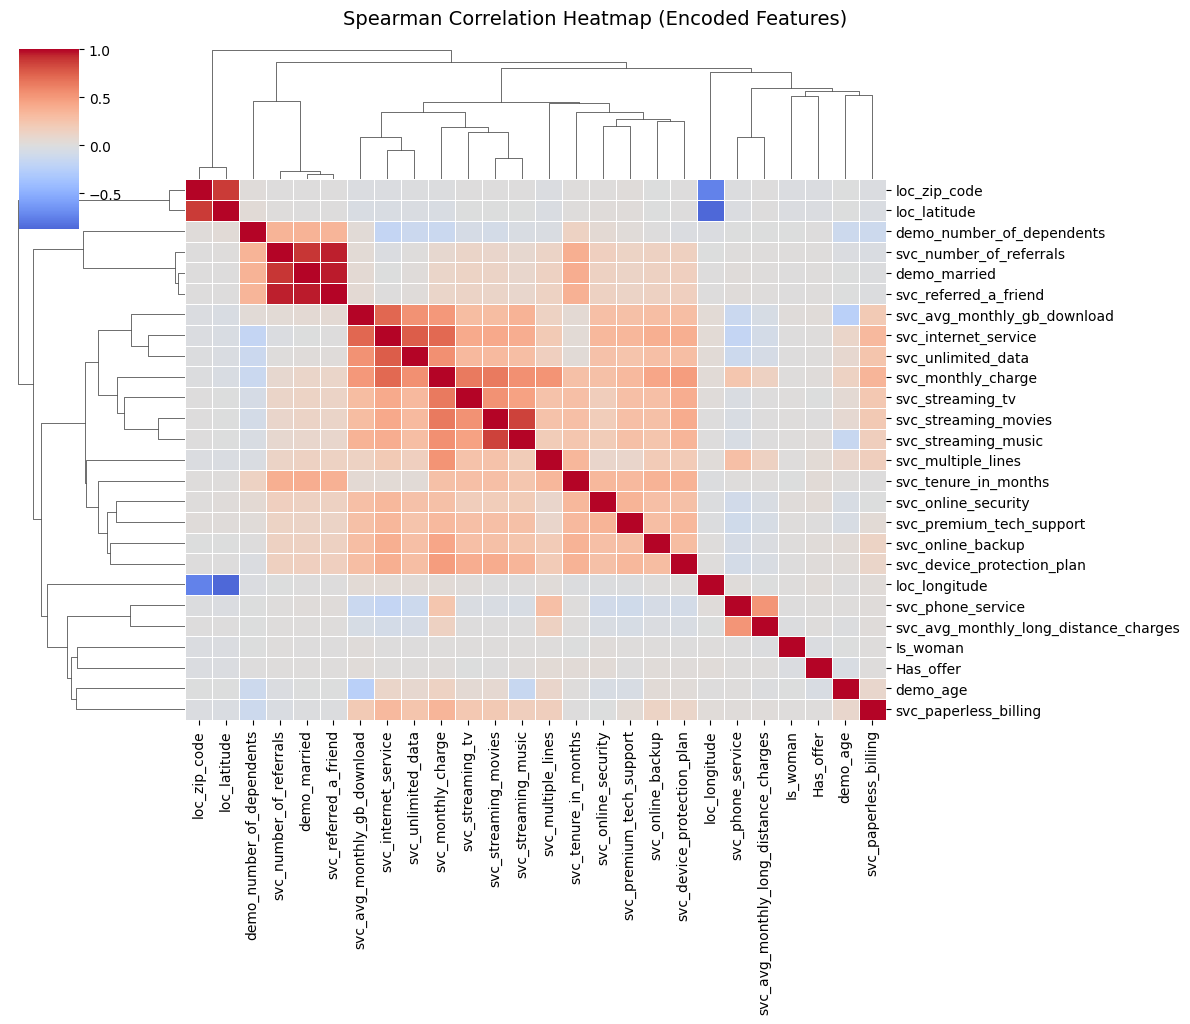

In [38]:
corr_spear = plot_spearman_heatmap_encoded(X, object_cols)


In [39]:
def high_correlations(corr_matrix, threshold=0.7):
    """
    Returns pairs of features with absolute correlation above the threshold.
    Useful to detect multicollinearity.
    """
    corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) >= threshold:
                corr_pairs.append((
                    corr_matrix.index[i],
                    corr_matrix.columns[j],
                    corr_value
                ))

    high_corr_df = pd.DataFrame(corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
    high_corr_df = high_corr_df.sort_values(by="Correlation", key=lambda x: abs(x), ascending=False)

    return high_corr_df


In [40]:
high_corr_df = high_correlations(corr_spear, threshold=0.7)
high_corr_df


,Feature 1,Feature 2,Correlation
0,demo_married,svc_referred_a_friend,0.949987
5,svc_referred_a_friend,svc_number_of_referrals,0.943566
1,demo_married,svc_number_of_referrals,0.896375
2,loc_zip_code,loc_latitude,0.879823
4,loc_latitude,loc_longitude,-0.869546
9,svc_streaming_movies,svc_streaming_music,0.848528
7,svc_internet_service,svc_unlimited_data,0.755734
3,loc_zip_code,loc_longitude,-0.741516
6,svc_internet_service,svc_avg_monthly_gb_download,0.717342
8,svc_internet_service,svc_monthly_charge,0.711107


__Redundant Variables__ - Spearman Correlation higher than |0.8|

| Combination | Split 1 | Split 2 | Split 3 | Split 4 | Split 5 |
| --- | --- | --- | --- | --- | --- |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |
| __VAR01__ | x | x | x | x | x |

### **6.1.4. Mutual Information (MI) Test [Continuous,categorical and binary data]**
**Purpose:**

Measure how much a feature reduces uncertainty about the target — captures any type of dependence, linear or non-linear.

**Used for:**
 - Numerical features
 - Binary features
 - One-hot encoded categorical features
 - Complex/non-linear relationships

**Why it matters:**

One of the strongest filter methods for feature selection because it detects relationships that correlations cannot.

In [41]:
# =============================================================
#    MUTUAL INFORMATION (CORRECT - NO SPLITS)
# =============================================================

def compute_mutual_information(X, y, object_cols):
    """
    Compute Mutual Information between each encoded feature and the target.
    Works for classification problems.
    """

    # 1) Encode X (usar a tua encode_data!)
    X_enc = encode_data(X, object_cols)

    # 2) Garantir y é binário (0/1)
    y_num = y.astype(int)

    # 3) Calcular MI
    mi = mutual_info_classif(X_enc, y_num, discrete_features="auto")

    # 4) Construir DataFrame para ordenar
    mi_df = pd.DataFrame({
        "feature": X_enc.columns,
        "mutual_info": mi
    })

    mi_df = mi_df.sort_values("mutual_info", ascending=False).reset_index(drop=True)

    print("\n================ MUTUAL INFORMATION ================")
    print(mi_df)
    print("\nFeatures com maior dependência do target no topo.")
    print("====================================================\n")

    return mi_df


In [43]:
mi_df = compute_mutual_information(X, y, object_cols)



================ MUTUAL INFORMATION ================
                                  feature  mutual_info
0                 svc_number_of_referrals     0.076341
1                    svc_tenure_in_months     0.070138
2                   svc_contract_Two Year     0.063773
3                      svc_monthly_charge     0.046505
4               demo_number_of_dependents     0.040229
5           svc_internet_type_Fiber Optic     0.036644
6                            loc_zip_code     0.036302
7                           loc_longitude     0.036113
8                            loc_latitude     0.032054
9           svc_internet_type_No Internet     0.028713
10         svc_payment_method_Credit Card     0.027013
11                   svc_internet_service     0.026878
12                  svc_contract_One Year     0.024720
13            svc_avg_monthly_gb_download     0.024536
14                  svc_paperless_billing     0.018768
15                  svc_referred_a_friend     0.017497
16         

In [44]:
def plot_mi_bar_grouped(
    mi_df,
    binary_cols,
    continuous_cols,
    ordinal_cols,
    cutoff=None,
    title="Mutual Information por tipo de variável",
    top_n=None,
    score_col="mutual_info"
):
    """
    Plota um gráfico de barras horizontal da Mutual Information, com cores por tipo de variável.

    Parameters
    ----------
    mi_df : pd.DataFrame
        DataFrame com pelo menos as colunas ['feature', score_col].
    binary_cols : list
        Lista de nomes de colunas binárias (0/1) no espaço original / encoded.
    continuous_cols : list
        Lista de colunas numéricas contínuas.
    ordinal_cols : list
        Lista de colunas ordinais.
    cutoff : float or None
        Valor para desenhar linha de corte vertical (ex: 0.02). Se None, não desenha.
    title : str
        Título do gráfico.
    top_n : int or None
        Se definido, plota apenas as top N features com maior MI.
    score_col : str
        Nome da coluna no mi_df que contém os scores de MI (por defeito 'mutual_info').
    """

    if score_col not in mi_df.columns:
        raise ValueError(f"mi_df precisa de ter a coluna '{score_col}'")

    # 1) Série com scores, index = feature
    mi_scores = mi_df.set_index("feature")[score_col].dropna().sort_values(ascending=True)

    # top N (opcional)
    if top_n is not None:
        mi_scores = mi_scores.tail(top_n)

    # 2) Identificar colunas categóricas/dummies = tudo o que não está nas listas base
    base_cols = set(binary_cols + continuous_cols + ordinal_cols)
    cat_dummy_cols = [col for col in mi_scores.index if col not in base_cols]

    # 3) Mapear cada coluna a um tipo
    feature_types = {}
    for col in mi_scores.index:
        if col in binary_cols:
            feature_types[col] = "binary"
        elif col in continuous_cols:
            feature_types[col] = "continuous"
        elif col in ordinal_cols:
            feature_types[col] = "ordinal"
        elif col in cat_dummy_cols:
            feature_types[col] = "categorical"
        else:
            feature_types[col] = "unknown"

    # 4) Cores por tipo
    color_map = {
        "binary": "tab:blue",
        "continuous": "tab:green",
        "ordinal": "tab:orange",
        "categorical": "tab:red",
        "unknown": "grey"
    }
    bar_colors = [color_map[feature_types[col]] for col in mi_scores.index]

    # 5) Plot
    plt.figure(figsize=(12, max(6, len(mi_scores) * 0.3)))
    plt.barh(mi_scores.index, mi_scores.values, color=bar_colors)

    plt.title(title, fontsize=14)
    plt.xlabel(score_col, fontsize=12)
    plt.ylabel("Features", fontsize=12)

    # 6) Linha de corte (vertical, porque gráfico é horizontal)
    if cutoff is not None:
        plt.axvline(x=cutoff, linestyle="--", linewidth=1.5)
        plt.text(
            cutoff,
            -0.5,
            f"cutoff = {cutoff:.3f}",
            ha="center",
            va="bottom"
        )

    # 7) Legenda
    legend_elements = [
        Patch(facecolor=color_map["binary"], label="Binary"),
        Patch(facecolor=color_map["continuous"], label="Continuous"),
        Patch(facecolor=color_map["ordinal"], label="Ordinal"),
        Patch(facecolor=color_map["categorical"], label="Categorical (dummies)")
    ]
    plt.legend(handles=legend_elements, loc="lower right")

    plt.tight_layout()
    plt.show()


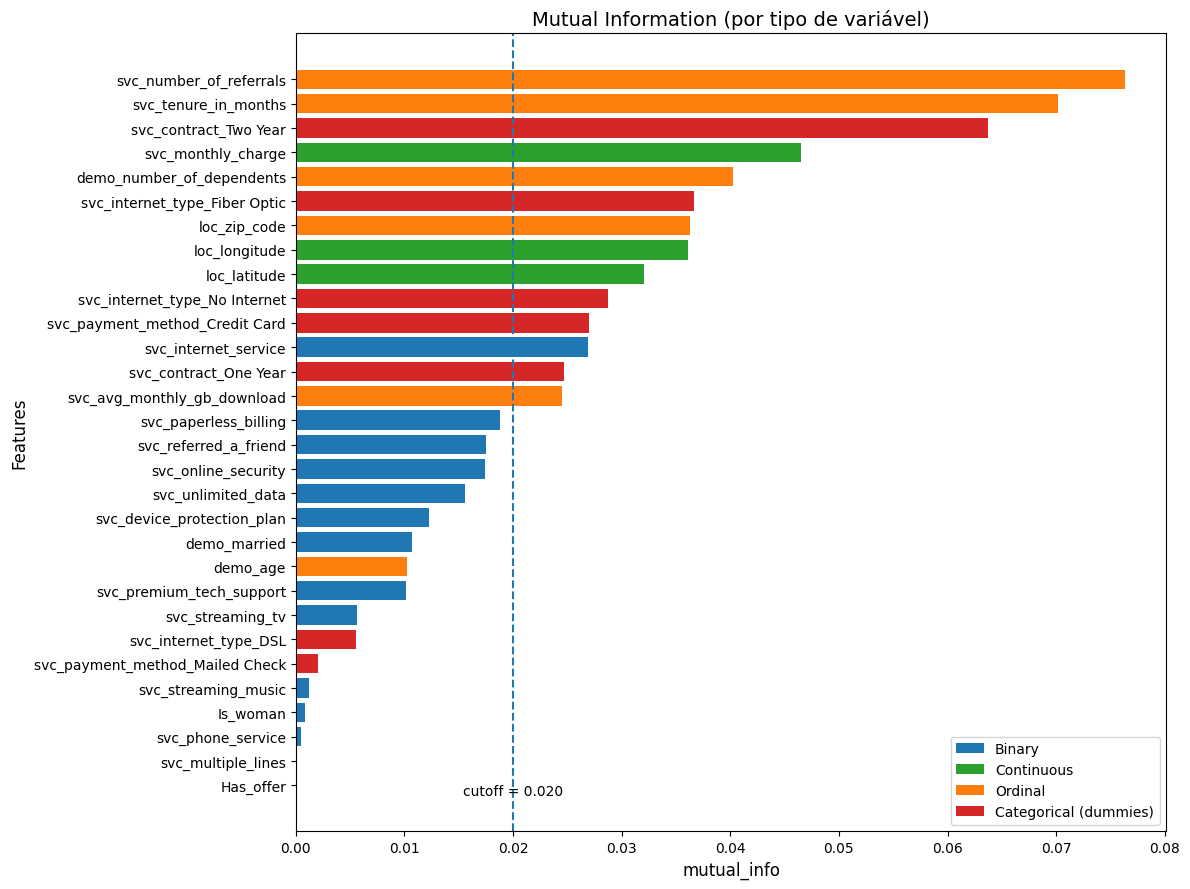

In [45]:
plot_mi_bar_grouped(
    mi_df,
    binary_cols=binary_cols,
    continuous_cols=continuous_cols,
    ordinal_cols=ordinal_cols,
    cutoff=0.02,                 # por exemplo
    title="Mutual Information (por tipo de variável)",
    top_n=30                     # por ex: top 30
)


### **6.1.5. Multicollinearity Correlation Check [Continuous, ordinal and binary data]**
**Method used:**

Feature-to-feature correlation (Pearson) — NOT feature vs target.

**Purpose:**

Identify pairs of features that are highly similar or redundant.

**Rules of thumb:**
 - |correlation| > 0.80 → suspicious
 - |correlation| > 0.85 → redundant
 - |correlation| > 0.90 → problematic

**Why it matters:**

Highly correlated features cause redundancy and can harm:
 - linear models
 - RFE
 - model stability
 - interpretability

In [46]:

def multicollinearity_correlation(X, 
                                  binary_cols,
                                  continuous_cols,
                                  ordinal_cols,
                                  object_cols,
                                  threshold=0.8):

    print("\n" + "="*120)
    print("                  CHECK DE MULTICOLINEARIDADE - CORRELAÇÃO ENTRE FEATURES")
    print("="*120)

    # 1) One Hot Encoding das variáveis categóricas
    X_enc = encode_data(X.copy(), object_cols)

    # 2) Selecionar apenas colunas numéricas
    numeric_cols = binary_cols + continuous_cols + ordinal_cols
    # acrescentar dummies criadas pelo encode_data (tudo o que não é numérico base nem objecto original)
    numeric_cols += [col for col in X_enc.columns if col not in numeric_cols and col not in object_cols]
    # remover duplicados mantendo ordem
    numeric_cols = list(dict.fromkeys(numeric_cols))

    X_num = X_enc[numeric_cols].select_dtypes(include=[np.number])

    # 3) Matriz de correlação absoluta
    corr_matrix = X_num.corr().abs()

    # 4) Zona superior da matriz (evita pares duplicados)
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # 5) Detetar pares com correlação acima do limiar
    high_corr_pairs = [
        (row, col, upper.loc[row, col])
        for row in upper.index
        for col in upper.columns
        if upper.loc[row, col] > threshold
    ]

    print(f"\nPares com correlação absoluta > {threshold}:\n")
    if len(high_corr_pairs) == 0:
        print("  Não foram encontrados pares com correlação elevada.")
    else:
        for f1, f2, val in high_corr_pairs:
            print(f"{f1}  <-->  {f2}   | corr = {val:.2f}")

    # 🔹 devolve 4 coisas
    return X_enc, X_num, corr_matrix, high_corr_pairs


In [47]:
# 1) Correlação entre features
X_enc_corr, X_num_corr, corr_matrix, high_corr_pairs = multicollinearity_correlation(
    X=X,
    binary_cols=binary_cols,
    continuous_cols=continuous_cols,
    ordinal_cols=ordinal_cols,
    object_cols=object_cols,
    threshold=0.7
)


                  CHECK DE MULTICOLINEARIDADE - CORRELAÇÃO ENTRE FEATURES

Pares com correlação absoluta > 0.7:

demo_married  <-->  svc_referred_a_friend   | corr = 0.95
svc_referred_a_friend  <-->  svc_number_of_referrals   | corr = 0.71
svc_internet_service  <-->  svc_unlimited_data   | corr = 0.76
svc_internet_service  <-->  svc_monthly_charge   | corr = 0.76
svc_streaming_movies  <-->  svc_streaming_music   | corr = 0.85
loc_latitude  <-->  loc_longitude   | corr = 0.89
loc_latitude  <-->  loc_zip_code   | corr = 0.89
loc_longitude  <-->  loc_zip_code   | corr = 0.79


### **6.1.6. Multicollinearity Check with VIF (Variance Inflation Factor) [Continuous, ordinal and binary data]**
**Method used:**

Regression-based method to compute:

𝑉𝐼𝐹=1/(1-R²) 

**Purpose:**

Quantify how much a feature is explained by the other features in the model.

**Interpretation:**
 - VIF = 1 → no collinearity
 - VIF = 2–5 → moderate
 - VIF > 5 → concerning
 - VIF > 10 → serious multicollinearity
 - VIF = ∞ → feature is a perfect linear combination of others

**Why it matters:**

VIF is the most formal and widely used measure of structural redundancy among variables.

In [48]:
def multicollinearity_vif_manual(X, 
                                 binary_cols,
                                 continuous_cols,
                                 ordinal_cols,
                                 object_cols):

    print("\n" + "="*120)
    print("          CHECK DE MULTICOLINEARIDADE - VIF (Variance Inflation Factor, sem statsmodels)")
    print("="*120)

    # 1) One Hot Encoding
    X_enc = encode_data(X.copy(), object_cols)

    # 2) Seleção das colunas numéricas
    numeric_cols = binary_cols + continuous_cols + ordinal_cols
    numeric_cols += [col for col in X_enc.columns if col not in numeric_cols and col not in object_cols]
    numeric_cols = list(dict.fromkeys(numeric_cols))

    X_num = X_enc[numeric_cols].select_dtypes(include=[np.number]).copy()

    vif_data = []

    # 3) Calcular VIF manualmente para cada feature
    for col in X_num.columns:
        y_feature = X_num[col]
        X_others = X_num.drop(columns=[col])

        if X_others.shape[1] == 0:
            vif = 1.0
        else:
            lr = LinearRegression()
            lr.fit(X_others, y_feature)
            r2 = lr.score(X_others, y_feature)

            if r2 >= 1.0:
                vif = np.inf
            else:
                vif = 1.0 / (1.0 - r2)

        vif_data.append((col, vif))

    vif_df = pd.DataFrame(vif_data, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)

    print("\nVIF por feature (ordenado do maior para o menor):\n")
    print(vif_df)

    print("\n  Features com VIF > 10 (multicolinearidade GRAVE):")
    high_vif = vif_df[vif_df["VIF"] > 10]
    if high_vif.empty:
        print("Nenhuma.")
    else:
        print(high_vif)

    print("\n  Features com VIF > 5 (multicolinearidade MODERADA):")
    moderate_vif = vif_df[(vif_df["VIF"] > 5) & (vif_df["VIF"] <= 10)]
    if moderate_vif.empty:
        print("Nenhuma.")
    else:
        print(moderate_vif)

    return X_enc, X_num, vif_df


In [49]:
# 2) VIF sem statsmodels
X_enc_vif, X_num_vif, vif_table = multicollinearity_vif_manual(
    X=X,
    binary_cols=binary_cols,
    continuous_cols=continuous_cols,
    ordinal_cols=ordinal_cols,
    object_cols=object_cols
)




          CHECK DE MULTICOLINEARIDADE - VIF (Variance Inflation Factor, sem statsmodels)

VIF por feature (ordenado do maior para o menor):

                                  feature        VIF
1                   svc_referred_a_friend  11.314334
19                     svc_monthly_charge  11.179747
0                            demo_married  10.571626
16                           loc_latitude   8.803214
4                    svc_internet_service   7.250235
10                   svc_streaming_movies   5.231532
22                           loc_zip_code   5.042371
17                          loc_longitude   4.667897
11                    svc_streaming_music   4.391610
2                       svc_phone_service   2.646793
12                     svc_unlimited_data   2.339795
23                svc_number_of_referrals   2.073319
9                        svc_streaming_tv   2.058992
25            svc_avg_monthly_gb_download   2.021553
24                   svc_tenure_in_months   1.839876
20        

## **6.2 Embedded Methods**
### **6.2.1 Embeded Methods with Cross Validation**
#### **6.2.1.1 XGBoost**

def select_best_features_embedded(
    X,
    y,
    object_cols,
    skf,
    estimator,
    model_name="Model",
    importance_threshold=None,
    top_k=None
):
    """
    Generic embedded feature selection using any estimator that provides
    feature_importances_ or coef_.

    Parameters
    ----------
    X : pd.DataFrame
        Original feature matrix (before encoding).
    y : pd.Series
        Target.
    object_cols : list
        Categorical columns (to be encoded).
    skf : StratifiedKFold
        Cross-validation splitter.
    estimator : sklearn estimator
        Base model (e.g. RF, DT, XGB, LogisticRegression).
    model_name : str
        Name for printing/plotting.
    importance_threshold : float or None
        If not None, select features with mean importance above this value.
    top_k : int or None
        If not None, select the top_k most important features.

    Returns
    -------
    mean_importances : pd.Series
        Mean feature importance across folds.
    fi_df : pd.DataFrame
        Feature importance per split.
    selected_features : list
        List of selected feature names.
    """
    # 1) Encode full dataset once
    X_enc = encode_data(X, object_cols)

    all_importances = []

    # 2) CV loop
    for count, (train_index, val_index) in enumerate(skf.split(X_enc, y), start=1):
        X_train, X_val = X_enc.iloc[train_index], X_enc.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        est = clone(estimator)
        est.fit(X_train, y_train)

        # Get importances or coefficients
        if hasattr(est, "feature_importances_"):
            fi = pd.Series(est.feature_importances_, index=X_train.columns)
        elif hasattr(est, "coef_"):
            coef = est.coef_
            # absolute value, average across classes if multiclass
            if coef.ndim == 1:
                imp = np.abs(coef)
            else:
                imp = np.mean(np.abs(coef), axis=0)
            fi = pd.Series(imp, index=X_train.columns)
        else:
            raise ValueError(
                f"Estimator {type(est).__name__} has neither "
                "feature_importances_ nor coef_."
            )

        all_importances.append(fi)

    # 3) Combine importances
    fi_df = pd.concat(all_importances, axis=1)
    fi_df.columns = [f"split_{i+1}" for i in range(len(all_importances))]

    # 4) Mean importance
    mean_importances = fi_df.mean(axis=1)
    mean_importances = mean_importances.sort_values(ascending=False)

    print(f"\nMean feature importance across splits ({model_name}):\n")
    print(mean_importances)

    # 5) Selection logic
    if top_k is not None:
        selected_features = mean_importances.head(top_k).index.tolist()
    elif importance_threshold is not None:
        selected_features = mean_importances[mean_importances > importance_threshold].index.tolist()
    else:
        threshold = mean_importances.mean()
        print(f"\n[{model_name}] Using default threshold = mean importance = {threshold:.4f}")
        selected_features = mean_importances[mean_importances > threshold].index.tolist()

    print(f"\nSelected features ({model_name}):")
    print(selected_features)

    # 6) Plot mean importances (assumindo que já tens esta função definida)
    plot_importance(mean_importances, f"{model_name} (mean over CV)")

    return mean_importances, fi_df, selected_features


In [50]:
def select_best_features_embedded(
    X_enc,
    y,
    skf,
    estimator,
    model_name="Model",
    importance_threshold=None,
    top_k=None
):
    """
    Generic embedded feature selection using any estimator that provides
    feature_importances_ or coef_.

    Parameters
    ----------
    X_enc : pd.DataFrame
        Encoded feature matrix (after encoding).
    y : pd.Series
        Target (numeric, e.g. 0/1).
    skf : StratifiedKFold
        Cross-validation splitter.
    estimator : sklearn estimator
        Base model (e.g. RF, DT, XGB, LogisticRegression).
    model_name : str
        Name for printing/plotting.
    importance_threshold : float or None
        If not None, select features with mean importance above this value.
    top_k : int or None
        If not None, select the top_k most important features.

    Returns
    -------
    mean_importances : pd.Series
        Mean feature importance across folds.
    fi_df : pd.DataFrame
        Feature importance per split.
    selected_features : list
        List of selected feature names.
    """

    all_importances = []

    # 1) CV loop
    for count, (train_index, val_index) in enumerate(skf.split(X_enc, y), start=1):
        X_train, X_val = X_enc.iloc[train_index], X_enc.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        est = clone(estimator)
        est.fit(X_train, y_train)

        # Get importances or coefficients
        if hasattr(est, "feature_importances_"):
            fi = pd.Series(est.feature_importances_, index=X_train.columns)
        elif hasattr(est, "coef_"):
            coef = est.coef_
            # absolute value, average across classes if multiclass
            if coef.ndim == 1:
                imp = np.abs(coef)
            else:
                imp = np.mean(np.abs(coef), axis=0)
            fi = pd.Series(imp, index=X_train.columns)
        else:
            raise ValueError(
                f"Estimator {type(est).__name__} has neither "
                "feature_importances_ nor coef_."
            )

        all_importances.append(fi)

    # 2) Combine importances
    fi_df = pd.concat(all_importances, axis=1)
    fi_df.columns = [f"split_{i+1}" for i in range(len(all_importances))]

    # 3) Mean importance
    mean_importances = fi_df.mean(axis=1)
    mean_importances = mean_importances.sort_values(ascending=False)

    print(f"\nMean feature importance across splits ({model_name}):\n")
    print(mean_importances)

    # 4) Selection logic
    if top_k is not None:
        selected_features = mean_importances.head(top_k).index.tolist()
    elif importance_threshold is not None:
        selected_features = mean_importances[mean_importances > importance_threshold].index.tolist()
    else:
        threshold = mean_importances.mean()
        print(f"\n[{model_name}] Using default threshold = mean importance = {threshold:.4f}")
        selected_features = mean_importances[mean_importances > threshold].index.tolist()

    print(f"\nSelected features ({model_name}):")
    print(selected_features)

    # 5) Plot mean importances (assumindo que já tens esta função definida)
    plot_importance(mean_importances, f"{model_name} (mean over CV)")

    return mean_importances, fi_df, selected_features


In [51]:
def plot_importance(variables, name):
    """
    Plot feature importances as a horizontal bar chart.
    """
    imp_features = variables.sort_values()
    plt.figure(figsize=(4, 8))
    imp_features.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()


Mean feature importance across splits (XGBoost (embedded)):

svc_contract_Two Year                    0.189349
svc_contract_One Year                    0.134222
svc_internet_service                     0.113344
svc_internet_type_Fiber Optic            0.061708
svc_number_of_referrals                  0.058755
svc_payment_method_Credit Card           0.043203
demo_number_of_dependents                0.036595
svc_referred_a_friend                    0.035091
svc_tenure_in_months                     0.026744
svc_streaming_movies                     0.026431
svc_online_security                      0.021761
svc_paperless_billing                    0.020458
demo_age                                 0.018800
svc_premium_tech_support                 0.018149
svc_monthly_charge                       0.016127
svc_streaming_music                      0.013413
svc_streaming_tv                         0.012806
demo_married                             0.012635
svc_internet_type_No Internet         

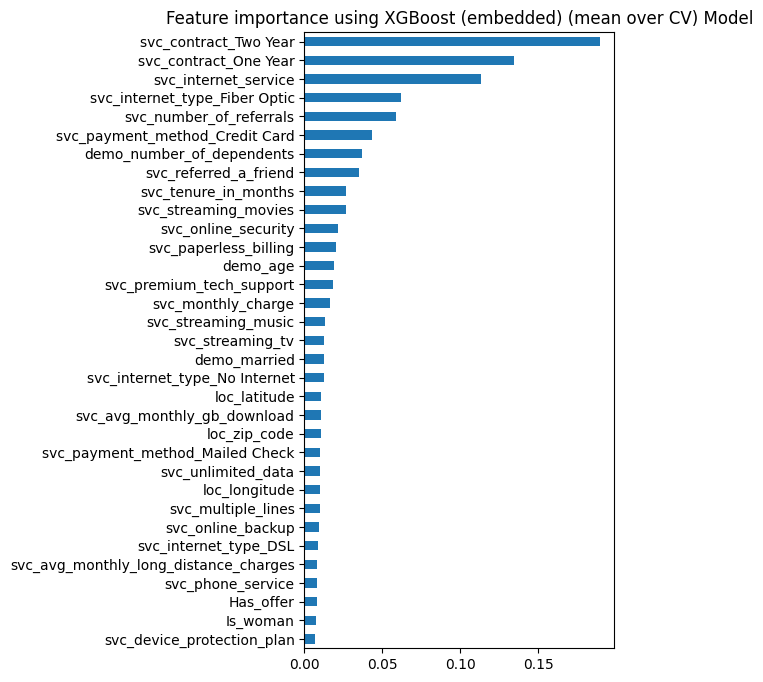

In [52]:
# XGBoost Classifier
xgb_est = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=99,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_mean_imp, xgb_imp_splits, xgb_selected_features = select_best_features_embedded(
    X_enc,
    y,
    skf,
    estimator=xgb_est,
    model_name="XGBoost (embedded)",
    importance_threshold=0.01,   # opcional
    top_k=15                     # por ex., top 15
)


#### **6.2.1.2 Random Forest**


Mean feature importance across splits (Random Forest (embedded)):

svc_tenure_in_months                     0.124881
svc_monthly_charge                       0.083844
svc_number_of_referrals                  0.069953
demo_age                                 0.065546
loc_latitude                             0.062177
loc_zip_code                             0.060960
loc_longitude                            0.060261
svc_avg_monthly_gb_download              0.057029
svc_contract_Two Year                    0.056739
svc_avg_monthly_long_distance_charges    0.056653
svc_contract_One Year                    0.030690
demo_number_of_dependents                0.030264
svc_internet_type_Fiber Optic            0.024161
svc_payment_method_Credit Card           0.020026
svc_premium_tech_support                 0.017980
svc_online_security                      0.017183
svc_paperless_billing                    0.014919
Has_offer                                0.011863
Is_woman                        

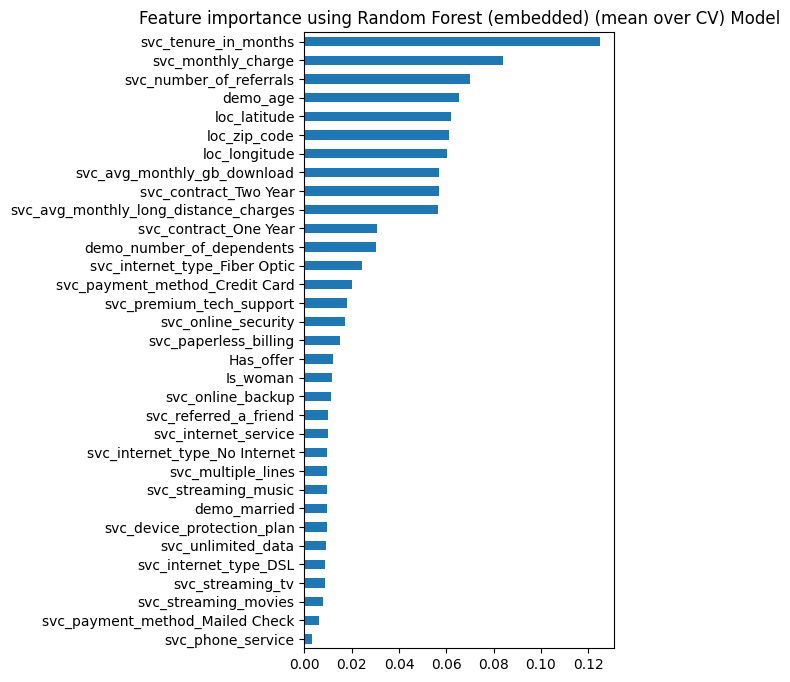

In [53]:
rf_est = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    random_state=99,
    n_jobs=-1
)

rf_mean_imp, rf_imp_splits, rf_selected_features = select_best_features_embedded(
    X_enc,
    y,
    skf,
    estimator=rf_est,
    model_name="Random Forest (embedded)",
    importance_threshold=0.01,
    top_k=15
)


#### **6.2.1.3 Logistic Regression**

c:\Users\sarac\rep_EDSB\EnterpriseDataScienceBootcamp_workgroup\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 12524 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sarac\rep_EDSB\EnterpriseDataScienceBootcamp_workgroup\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 12509 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver op


Mean feature importance across splits (Logistic Regression (embedded)):

svc_contract_Two Year                    2.402242
svc_contract_One Year                    1.342657
svc_referred_a_friend                    1.117234
svc_phone_service                        0.910338
demo_married                             0.666588
svc_payment_method_Mailed Check          0.620555
demo_number_of_dependents                0.590554
svc_number_of_referrals                  0.583267
svc_online_security                      0.465396
svc_premium_tech_support                 0.458357
svc_payment_method_Credit Card           0.392198
svc_internet_type_Fiber Optic            0.358292
svc_paperless_billing                    0.282461
svc_streaming_music                      0.271622
svc_online_backup                        0.256571
svc_internet_type_DSL                    0.229996
svc_streaming_movies                     0.225145
svc_internet_service                     0.126947
svc_internet_type_No Inter

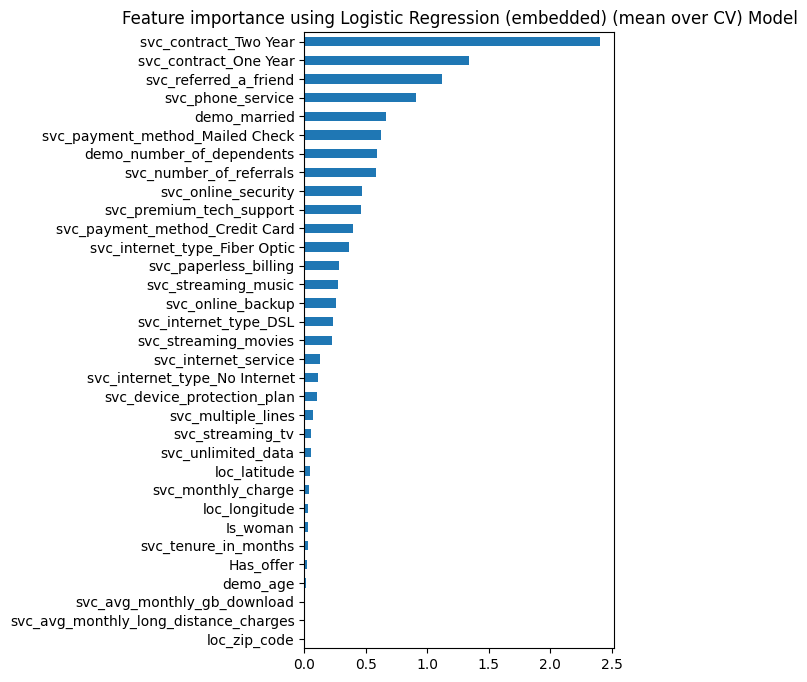

In [54]:
log_est = LogisticRegression(
    max_iter=20000,
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced"
)

log_mean_imp, log_imp_splits, log_selected_features = select_best_features_embedded(
    X_enc,
    y,
    skf,
    estimator=log_est,
    model_name="Logistic Regression (embedded)",
    importance_threshold=None,  # podes usar default = média
    top_k=15
)


#### **6.2.1.4 Decision Trees**


Mean feature importance across splits (Decision Tree (embedded)):

svc_tenure_in_months                     0.116688
svc_monthly_charge                       0.105230
demo_age                                 0.101374
svc_contract_Two Year                    0.083491
svc_contract_One Year                    0.071335
svc_number_of_referrals                  0.069225
svc_avg_monthly_long_distance_charges    0.067215
loc_longitude                            0.062138
loc_zip_code                             0.055216
loc_latitude                             0.052677
svc_avg_monthly_gb_download              0.050059
demo_number_of_dependents                0.026171
svc_internet_type_Fiber Optic            0.014221
svc_payment_method_Credit Card           0.014062
svc_referred_a_friend                    0.010645
svc_paperless_billing                    0.009383
svc_online_security                      0.007312
svc_streaming_music                      0.007149
svc_unlimited_data              

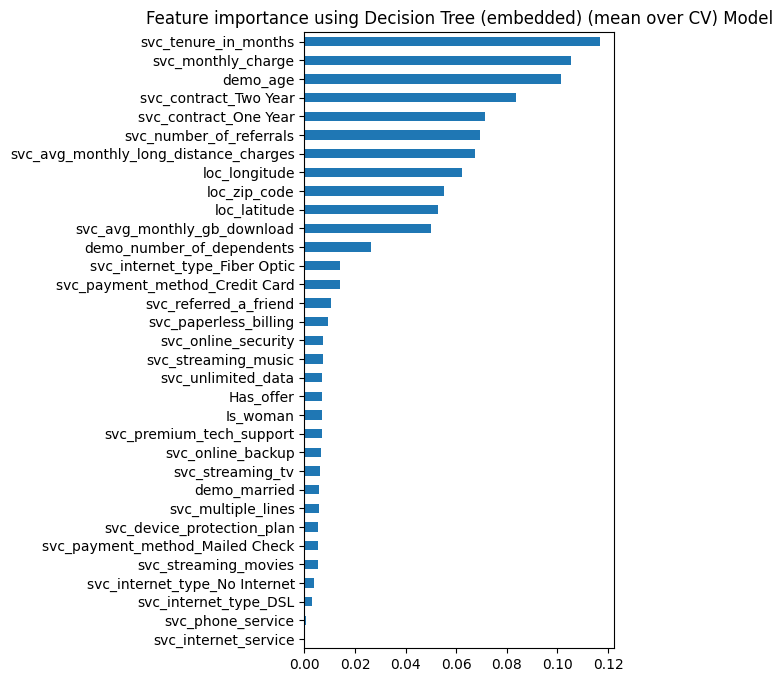

In [55]:
dt_est = DecisionTreeClassifier(
    random_state=99,
    max_depth=None
)

dt_mean_imp, dt_imp_splits, dt_selected_features = select_best_features_embedded(
    X_enc,
    y,
    skf,
    estimator=dt_est,
    model_name="Decision Tree (embedded)",
    importance_threshold=0.01,   # ou None se preferires top_k
    top_k=15
)


#### **6.2.1.5 Logistic Regression L1**


Mean feature importance across splits (Logistic Regression L1 (embedded)):

svc_contract_Two Year                    2.381915
svc_referred_a_friend                    1.328185
svc_contract_One Year                    1.284563
demo_number_of_dependents                0.620282
svc_internet_type_No Internet            0.597092
svc_number_of_referrals                  0.588153
svc_payment_method_Mailed Check          0.554409
svc_phone_service                        0.551879
demo_married                             0.494845
svc_payment_method_Credit Card           0.433943
svc_premium_tech_support                 0.400531
svc_online_security                      0.387802
svc_internet_type_Fiber Optic            0.364052
svc_internet_type_DSL                    0.300186
svc_paperless_billing                    0.299155
svc_streaming_tv                         0.238623
svc_multiple_lines                       0.224899
svc_streaming_music                      0.214378
svc_online_backup      

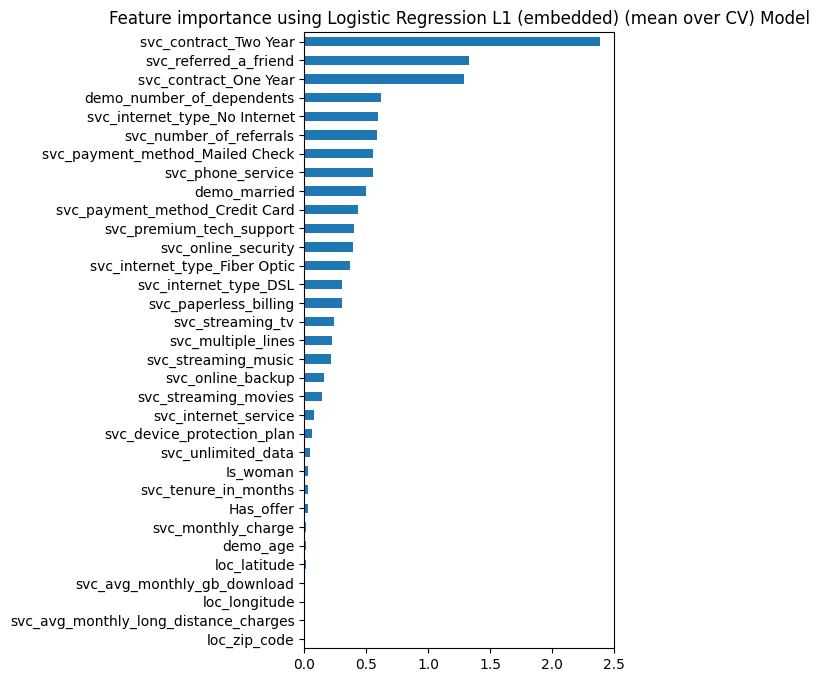

In [56]:
log_l1_est = LogisticRegression(
    penalty="l1",
    solver="liblinear",   # ou 'saga' se tiveres mais dados
    max_iter=3000
)

log_l1_mean_imp, log_l1_imp_splits, log_l1_selected_features = select_best_features_embedded(
    X_enc,
    y,
    skf,
    estimator=log_l1_est,
    model_name="Logistic Regression L1 (embedded)",
    importance_threshold=None,   # podes deixar usar a média
    top_k=15
)


### **6.2.2 Summarising and Comparison between Embeded Methods**

In [57]:
# ============================================================
#   CONSENSUS TABLE FOR EMBEDDED METHODS (RF, XGB, LOGREG)
# ============================================================

def build_embedded_consensus(rf_imp, xgb_imp, log_imp):
    """
    Build a unified table combining embedded feature importances from
    Random Forest, XGBoost, and Logistic Regression.
    """

    # Convert Series to DataFrames
    rf_df = rf_imp.reset_index()
    rf_df.columns = ["feature", "imp_rf"]

    xgb_df = xgb_imp.reset_index()
    xgb_df.columns = ["feature", "imp_xgb"]

    log_df = log_imp.reset_index()
    log_df.columns = ["feature", "imp_log"]

    # Outer join on feature name (include all features)
    imp_all = rf_df.merge(xgb_df, on="feature", how="outer") \
                   .merge(log_df, on="feature", how="outer")

    # Fill NaN (in case some models assigned zero importance)
    imp_all = imp_all.fillna(0.0)

    # NORMALIZE IMPORTANCE PER MODEL (0–1 scale)
    for col in ["imp_rf", "imp_xgb", "imp_log"]:
        max_val = imp_all[col].max()
        if max_val > 0:
            imp_all[col] = imp_all[col] / max_val

    # Average importance
    imp_all["avg_imp"] = imp_all[["imp_rf", "imp_xgb", "imp_log"]].mean(axis=1)

    # Number of models that selected feature (>0 importance)
    imp_all["models_selected"] = (
        (imp_all["imp_rf"] > 0).astype(int)
        + (imp_all["imp_xgb"] > 0).astype(int)
        + (imp_all["imp_log"] > 0).astype(int)
    )

    # Sort by average importance
    imp_all = imp_all.sort_values("avg_imp", ascending=False).reset_index(drop=True)

    return imp_all


In [58]:
imp_all = build_embedded_consensus(rf_mean_imp, xgb_mean_imp, log_mean_imp)
imp_all.head(20)

,feature,imp_rf,imp_xgb,imp_log,avg_imp,models_selected
0,svc_contract_Two Year,0.454344,1.000000,1.000000,0.818115,3
1,svc_contract_One Year,0.245754,0.708861,0.558918,0.504511,3
2,svc_tenure_in_months,1.000000,0.141241,0.010720,0.383987,3
3,svc_number_of_referrals,0.560158,0.310298,0.242801,0.371086,3
4,svc_monthly_charge,0.671393,0.085173,0.014373,0.256979,3
5,svc_internet_service,0.081041,0.598600,0.052845,0.244162,3
6,svc_referred_a_friend,0.081098,0.185324,0.465080,0.243834,3
7,demo_number_of_dependents,0.242340,0.193267,0.245835,0.227147,3
8,svc_internet_type_Fiber Optic,0.193471,0.325895,0.149149,0.222838,3
9,demo_age,0.524868,0.099287,0.005407,0.209854,3


In [59]:
def plot_embedded_comparison(imp_all, top_n=20):
    """
    Horizontal grouped bar chart comparing RF, XGB and LogReg importances.
    """
    imp_plot = imp_all.head(top_n).iloc[::-1]  # invert to plot top at top

    features = imp_plot["feature"].values
    idx = np.arange(len(features))

    rf_vals = imp_plot["imp_rf"].values
    xgb_vals = imp_plot["imp_xgb"].values
    log_vals = imp_plot["imp_log"].values

    bar_w = 0.25

    plt.figure(figsize=(12, 6 + top_n * 0.2))

    plt.barh(idx - bar_w, rf_vals, height=bar_w, label="Random Forest")
    plt.barh(idx,         xgb_vals, height=bar_w, label="XGBoost")
    plt.barh(idx + bar_w, log_vals, height=bar_w, label="LogReg (abs coef)")

    plt.yticks(idx, features)
    plt.xlabel("Normalized Importance")
    plt.title(f"Embedded Methods Comparison (Top {top_n})")

    plt.legend()
    plt.tight_layout()
    plt.show()


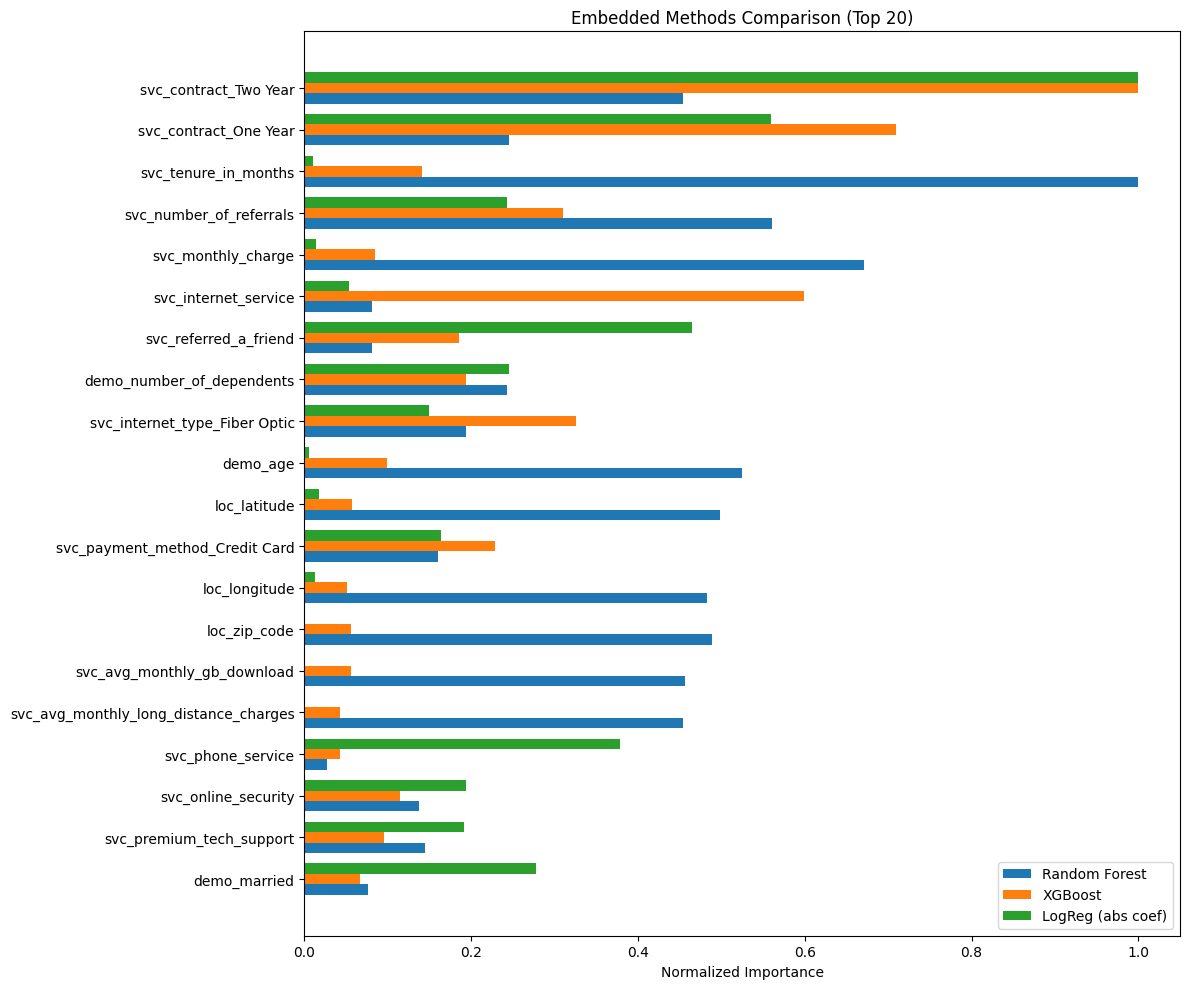

In [60]:
plot_embedded_comparison(imp_all, top_n=20)


#### **6.2.2.1 Strict intersection consensus (features important in all three models)**

In [61]:
# 1) Estrito: selecionadas pelos 3 modelos
consensus_3of3_embeded = imp_all[imp_all["models_selected"] == 3]["feature"].tolist()

print("\n=== STRICT CONSENSUS (3/3 models) ===")
consensus_3of3_embeded


=== STRICT CONSENSUS (3/3 models) ===


['svc_contract_Two Year',
 'svc_contract_One Year',
 'svc_tenure_in_months',
 'svc_number_of_referrals',
 'svc_monthly_charge',
 'svc_internet_service',
 'svc_referred_a_friend',
 'demo_number_of_dependents',
 'svc_internet_type_Fiber Optic',
 'demo_age',
 'loc_latitude',
 'svc_payment_method_Credit Card',
 'loc_longitude',
 'loc_zip_code',
 'svc_avg_monthly_gb_download',
 'svc_avg_monthly_long_distance_charges',
 'svc_phone_service',
 'svc_online_security',
 'svc_premium_tech_support',
 'demo_married',
 'svc_payment_method_Mailed Check',
 'svc_paperless_billing',
 'svc_streaming_movies',
 'svc_streaming_music',
 'svc_online_backup',
 'svc_internet_type_DSL',
 'svc_internet_type_No Internet',
 'svc_multiple_lines',
 'svc_streaming_tv',
 'svc_device_protection_plan',
 'svc_unlimited_data',
 'Has_offer',
 'Is_woman']

#### **6.2.2.2 Soft consensus (features selected by at least two models)**

In [62]:
# 2) Majority: selecionadas por pelo menos 2 modelos
consensus_2of3_embeded = imp_all[imp_all["models_selected"] >= 2]["feature"].tolist()

print("\n=== MAJORITY CONSENSUS (≥2 models) ===")
consensus_2of3_embeded


=== MAJORITY CONSENSUS (≥2 models) ===


['svc_contract_Two Year',
 'svc_contract_One Year',
 'svc_tenure_in_months',
 'svc_number_of_referrals',
 'svc_monthly_charge',
 'svc_internet_service',
 'svc_referred_a_friend',
 'demo_number_of_dependents',
 'svc_internet_type_Fiber Optic',
 'demo_age',
 'loc_latitude',
 'svc_payment_method_Credit Card',
 'loc_longitude',
 'loc_zip_code',
 'svc_avg_monthly_gb_download',
 'svc_avg_monthly_long_distance_charges',
 'svc_phone_service',
 'svc_online_security',
 'svc_premium_tech_support',
 'demo_married',
 'svc_payment_method_Mailed Check',
 'svc_paperless_billing',
 'svc_streaming_movies',
 'svc_streaming_music',
 'svc_online_backup',
 'svc_internet_type_DSL',
 'svc_internet_type_No Internet',
 'svc_multiple_lines',
 'svc_streaming_tv',
 'svc_device_protection_plan',
 'svc_unlimited_data',
 'Has_offer',
 'Is_woman']

#### **6.2.2.3 Top-N features by normalized mean importance**

In [63]:
# 3) Top N pela média das importâncias
TOP_N = 20
consensus_topN_embeded = imp_all.head(TOP_N)["feature"].tolist()

print(f"\n=== TOP {TOP_N} BY MEAN NORMALIZED IMPORTANCE ===")
consensus_topN_embeded


=== TOP 20 BY MEAN NORMALIZED IMPORTANCE ===


['svc_contract_Two Year',
 'svc_contract_One Year',
 'svc_tenure_in_months',
 'svc_number_of_referrals',
 'svc_monthly_charge',
 'svc_internet_service',
 'svc_referred_a_friend',
 'demo_number_of_dependents',
 'svc_internet_type_Fiber Optic',
 'demo_age',
 'loc_latitude',
 'svc_payment_method_Credit Card',
 'loc_longitude',
 'loc_zip_code',
 'svc_avg_monthly_gb_download',
 'svc_avg_monthly_long_distance_charges',
 'svc_phone_service',
 'svc_online_security',
 'svc_premium_tech_support',
 'demo_married']

## **6.3 Wrapper Methods**

### **6.3.1 Recursive Feature Elimination (RFE) – Cross Validation**

In [64]:
def select_features_rfecv(
    X_enc,
    y,
    skf,
    estimator=None,
    scoring="accuracy",
    step=1,
    min_features_to_select=1,
    importance_getter="auto"
):
    """
    Wrapper method using RFECV (Recursive Feature Elimination with Cross-Validation).
    Assumes X_enc is already encoded.
    """
    # 1) Default estimator -> RandomForest
    if estimator is None:
        estimator = RandomForestClassifier(
            n_estimators=200,
            random_state=99,
            n_jobs=-1
        )
    
    # 2) RFECV setup
    rfecv = RFECV(
        estimator=estimator,
        step=step,
        cv=skf,
        scoring=scoring,
        n_jobs=-1,
        min_features_to_select=min_features_to_select,
        importance_getter=importance_getter
    )
    
    # 3) Fit RFECV
    rfecv.fit(X_enc, y)
    
    # 4) Extract selected features
    selected_mask = rfecv.support_
    selected_features = X_enc.columns[selected_mask].tolist()
    
    print("\nOptimal number of features:", rfecv.n_features_)
    print("\nSelected features (Wrapper - RFECV):")
    print(selected_features)
    
    # 5) Plot CV score vs number of features
    try:
        scores = rfecv.grid_scores_
    except AttributeError:
        scores = rfecv.cv_results_["mean_test_score"]

    n_features = range(1, len(scores) + 1)

    plt.figure(figsize=(5, 4))
    plt.plot(n_features, scores)
    plt.xlabel("Number of features selected")
    plt.ylabel(scoring)
    plt.title("RFECV - " + type(estimator).__name__)
    plt.tight_layout()
    plt.show()

    # 6) Build ranking dataframe
    feature_names = X_enc.columns
    ranking = rfecv.ranking_
    support = rfecv.support_

    data = {
        "feature": feature_names,
        "selected": support,
        "ranking": ranking
    }

    # Try extract quantitative importance
    est = getattr(rfecv, "estimator_", None)
    if est is not None:
        # If estimator is a Pipeline, get the last step that has coef_ or feature_importances_
        if isinstance(est, Pipeline):
            inner_est = None
            for name, step in reversed(est.steps):
                if hasattr(step, "feature_importances_") or hasattr(step, "coef_"):
                    inner_est = step
                    break
            if inner_est is None:
                inner_est = list(est.named_steps.values())[-1]
        else:
            inner_est = est

        imp = None

        if hasattr(inner_est, "feature_importances_"):
            imp = inner_est.feature_importances_

        elif hasattr(inner_est, "coef_"):
            coef = inner_est.coef_
            if coef.ndim == 1:
                imp = np.abs(coef)
            else:
                imp = np.mean(np.abs(coef), axis=0)

        if imp is not None:
            importance_full = np.zeros(len(feature_names))
            importance_full[support] = imp
            data["importance"] = importance_full

    importance_df = pd.DataFrame(data)

    sort_cols = ["selected"]
    ascending = [False]

    if "importance" in importance_df.columns:
        sort_cols.append("importance")
        ascending.append(False)
    else:
        sort_cols.append("ranking")
        ascending.append(True)

    importance_df = importance_df.sort_values(sort_cols, ascending=ascending).reset_index(drop=True)

    print("\nFeature ranking (top 20):")
    display(importance_df.head(20))

    return selected_features, rfecv, X_enc, importance_df


#### **6.3.1.1 RFECV with XGBoost**


Optimal number of features: 21

Selected features (Wrapper - RFECV):
['demo_age', 'demo_married', 'demo_number_of_dependents', 'loc_zip_code', 'loc_latitude', 'svc_referred_a_friend', 'svc_number_of_referrals', 'svc_tenure_in_months', 'svc_internet_service', 'svc_online_security', 'svc_premium_tech_support', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'svc_paperless_billing', 'svc_monthly_charge', 'svc_internet_type_Fiber Optic', 'svc_contract_One Year', 'svc_contract_Two Year', 'svc_payment_method_Credit Card', 'svc_payment_method_Mailed Check']


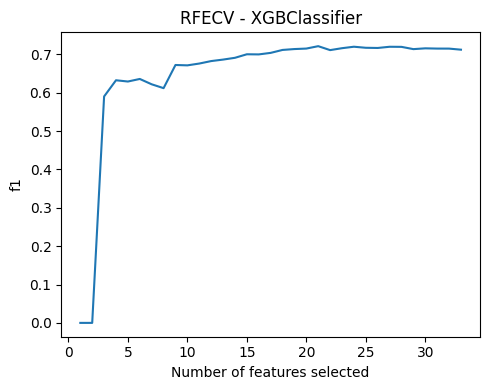


Feature ranking (top 20):


,feature,selected,ranking,importance
0,svc_contract_Two Year,True,1,0.222297
1,svc_contract_One Year,True,1,0.151596
2,svc_internet_service,True,1,0.105037
3,svc_number_of_referrals,True,1,0.071372
4,svc_payment_method_Credit Card,True,1,0.051983
5,svc_internet_type_Fiber Optic,True,1,0.050111
6,svc_referred_a_friend,True,1,0.048455
7,demo_number_of_dependents,True,1,0.042522
8,svc_online_security,True,1,0.034566
9,svc_streaming_movies,True,1,0.029682


In [65]:
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=99,
    n_jobs=-1,
    eval_metric="logloss"
)


selected_features_xgb, rfecv_xgb, X_enc, importance_xgb = select_features_rfecv(
    X_enc,
    y,                 # 0/1
    skf,
    estimator=xgb_clf,
    scoring="f1"       # pos_label=1 por default, está OK
)

#### **6.3.1.2 RFECV with Random Forest Classifier**


Optimal number of features: 27

Selected features (Wrapper - RFECV):
['demo_age', 'demo_married', 'demo_number_of_dependents', 'loc_zip_code', 'loc_latitude', 'loc_longitude', 'svc_referred_a_friend', 'svc_number_of_referrals', 'svc_tenure_in_months', 'svc_avg_monthly_long_distance_charges', 'svc_multiple_lines', 'svc_avg_monthly_gb_download', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_streaming_music', 'svc_unlimited_data', 'svc_paperless_billing', 'svc_monthly_charge', 'Is_woman', 'Has_offer', 'svc_internet_type_Fiber Optic', 'svc_internet_type_No Internet', 'svc_contract_One Year', 'svc_contract_Two Year', 'svc_payment_method_Credit Card']


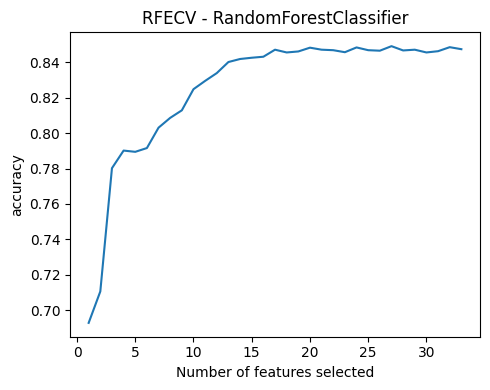


Feature ranking (top 20):


,feature,selected,ranking,importance
0,svc_tenure_in_months,True,1,0.128580
1,svc_monthly_charge,True,1,0.088719
2,svc_number_of_referrals,True,1,0.071123
3,demo_age,True,1,0.070167
4,loc_zip_code,True,1,0.064123
5,loc_latitude,True,1,0.063724
6,loc_longitude,True,1,0.062549
7,svc_contract_Two Year,True,1,0.061903
8,svc_avg_monthly_gb_download,True,1,0.061592
9,svc_avg_monthly_long_distance_charges,True,1,0.060340


In [66]:
selected_features_rf, rfecv_obj, X_enc, importance_rf = select_features_rfecv(
    X_enc,
    y,
    skf,
    scoring="accuracy"
)


#### **6.3.1.3 RFECV with Logistic Regression**

c:\Users\sarac\rep_EDSB\EnterpriseDataScienceBootcamp_workgroup\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sarac\rep_EDSB\EnterpriseDataScienceBootcamp_workgroup\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the d


Optimal number of features: 31

Selected features (Wrapper - RFECV):
['demo_age', 'demo_married', 'demo_number_of_dependents', 'loc_latitude', 'loc_longitude', 'svc_referred_a_friend', 'svc_number_of_referrals', 'svc_tenure_in_months', 'svc_phone_service', 'svc_multiple_lines', 'svc_internet_service', 'svc_avg_monthly_gb_download', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'svc_unlimited_data', 'svc_paperless_billing', 'svc_monthly_charge', 'Is_woman', 'Has_offer', 'svc_internet_type_DSL', 'svc_internet_type_Fiber Optic', 'svc_internet_type_No Internet', 'svc_contract_One Year', 'svc_contract_Two Year', 'svc_payment_method_Credit Card', 'svc_payment_method_Mailed Check']


c:\Users\sarac\rep_EDSB\EnterpriseDataScienceBootcamp_workgroup\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


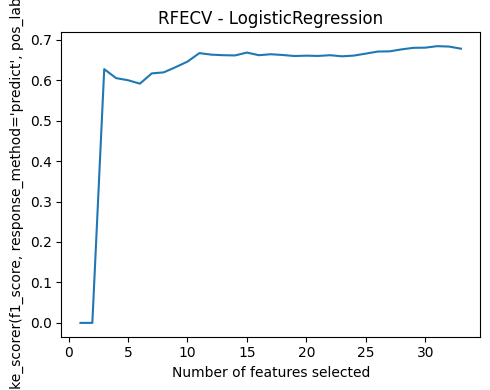


Feature ranking (top 20):


,feature,selected,ranking,importance
0,svc_contract_Two Year,True,1,2.354851
1,svc_phone_service,True,1,1.954503
2,svc_internet_service,True,1,1.534714
3,svc_internet_type_Fiber Optic,True,1,1.407346
4,svc_contract_One Year,True,1,1.279524
5,svc_referred_a_friend,True,1,1.254872
6,svc_premium_tech_support,True,1,0.735315
7,svc_streaming_movies,True,1,0.734137
8,svc_online_security,True,1,0.713370
9,svc_payment_method_Mailed Check,True,1,0.635037


In [67]:
# classe positiva = "Yes"
f1_yes_scorer = make_scorer(f1_score, pos_label=1)

log_reg = LogisticRegression(
    max_iter=3000,   # bastantes iterações para garantir convergência
    penalty="l2",
    solver="lbfgs"
)


selected_features_log, rfecv_log, X_enc, importance_log = select_features_rfecv(
    X_enc,
    y,
    skf,
    estimator=log_reg,
    scoring=f1_yes_scorer
)


#### **6.3.1.4 RFECV with DecisionTreeClassifier**


Optimal number of features: 33

Selected features (Wrapper - RFECV):
['demo_age', 'demo_married', 'demo_number_of_dependents', 'loc_zip_code', 'loc_latitude', 'loc_longitude', 'svc_referred_a_friend', 'svc_number_of_referrals', 'svc_tenure_in_months', 'svc_phone_service', 'svc_avg_monthly_long_distance_charges', 'svc_multiple_lines', 'svc_internet_service', 'svc_avg_monthly_gb_download', 'svc_online_security', 'svc_online_backup', 'svc_device_protection_plan', 'svc_premium_tech_support', 'svc_streaming_tv', 'svc_streaming_movies', 'svc_streaming_music', 'svc_unlimited_data', 'svc_paperless_billing', 'svc_monthly_charge', 'Is_woman', 'Has_offer', 'svc_internet_type_DSL', 'svc_internet_type_Fiber Optic', 'svc_internet_type_No Internet', 'svc_contract_One Year', 'svc_contract_Two Year', 'svc_payment_method_Credit Card', 'svc_payment_method_Mailed Check']


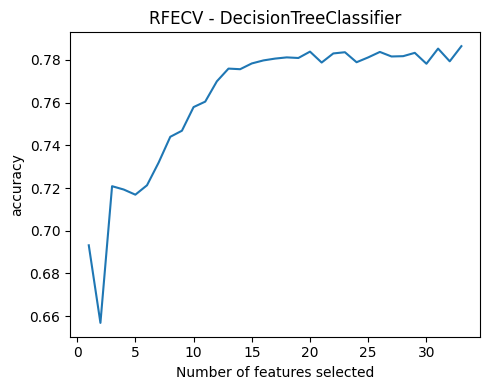


Feature ranking (top 20):


,feature,selected,ranking,importance
0,demo_age,True,1,0.112467
1,svc_contract_Two Year,True,1,0.107712
2,svc_contract_One Year,True,1,0.097498
3,svc_monthly_charge,True,1,0.086946
4,svc_tenure_in_months,True,1,0.081629
5,svc_number_of_referrals,True,1,0.070469
6,loc_zip_code,True,1,0.063723
7,loc_latitude,True,1,0.059304
8,loc_longitude,True,1,0.057390
9,svc_avg_monthly_long_distance_charges,True,1,0.056673


In [68]:
dt = DecisionTreeClassifier(random_state=99)

selected_features_dt_wrap, rfecv_dt, X_enc, importance_dt = select_features_rfecv(
    X_enc,
    y,
    skf,
    estimator=dt,
    scoring="accuracy"
)

### **6.3.2 Summarizing Recursive Feature Elimination analisys**

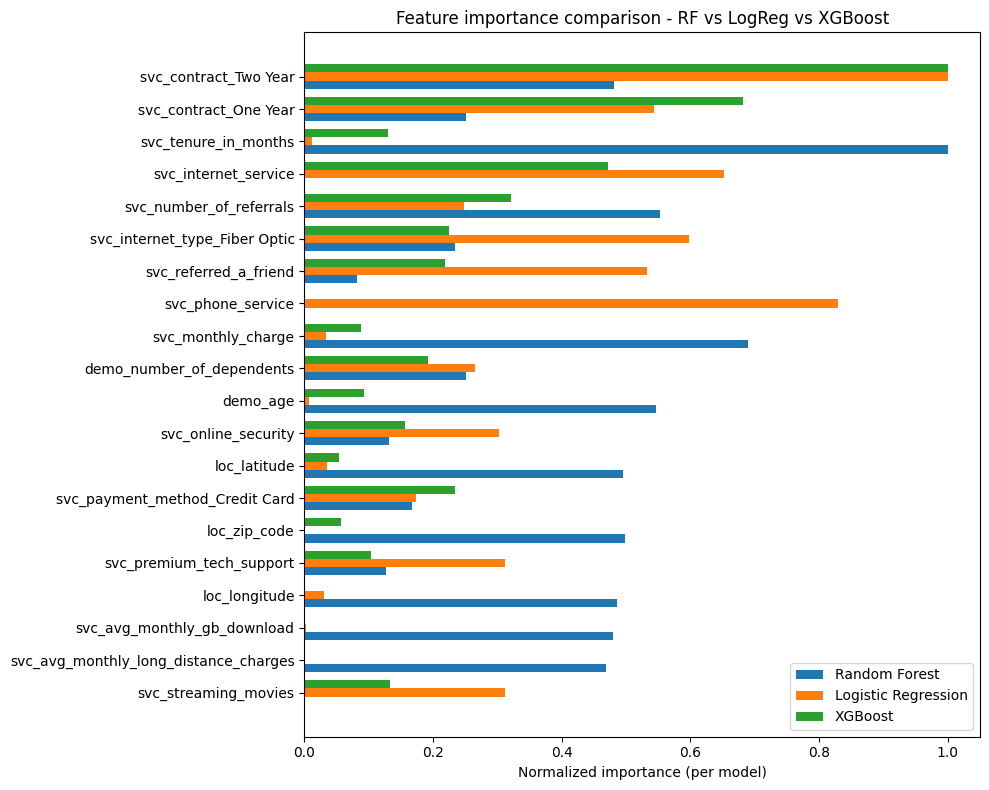

In [69]:
# ==========================================================
#  BEFORE creating rf / log / xgb dataframes
#  ensure all importance tables HAVE an 'importance' column
# ==========================================================

for df in [importance_rf, importance_log, importance_xgb]:
    if "importance" not in df.columns:
        df["importance"] = 0.0


# ==========================================================
#  FROM HERE ON your original code works perfectly
# ==========================================================

# 1) Make copies and keep only relevant columns
rf = importance_rf[["feature", "importance"]].copy()
log = importance_log[["feature", "importance"]].copy()
xgb = importance_xgb[["feature", "importance"]].copy()

rf.rename(columns={"importance": "importance_rf"}, inplace=True)
log.rename(columns={"importance": "importance_log"}, inplace=True)
xgb.rename(columns={"importance": "importance_xgb"}, inplace=True)

# 2) Merge on feature name (outer join to incluir tudo)
imp_merged = rf.merge(log, on="feature", how="outer") \
               .merge(xgb, on="feature", how="outer")

# 3) Replace NaNs
imp_merged[["importance_rf", "importance_log", "importance_xgb"]] = \
    imp_merged[["importance_rf", "importance_log", "importance_xgb"]].fillna(0.0)

# 4) Normalize importances per model (so that each model's max = 1)
for col in ["importance_rf", "importance_log", "importance_xgb"]:
    max_val = imp_merged[col].max()
    if max_val > 0:
        imp_merged[col] = imp_merged[col] / max_val

# 5) Choose which features to plot
imp_merged["avg_importance"] = imp_merged[
    ["importance_rf", "importance_log", "importance_xgb"]
].mean(axis=1)

TOP_N = 20
imp_top = imp_merged.sort_values("avg_importance", ascending=False).head(TOP_N)

imp_top = imp_top.iloc[::-1]

features = imp_top["feature"].values
idx = np.arange(len(features))

rf_vals = imp_top["importance_rf"].values
log_vals = imp_top["importance_log"].values
xgb_vals = imp_top["importance_xgb"].values

# 6) Plot
bar_width = 0.25

plt.figure(figsize=(10, 8))

plt.barh(idx - bar_width, rf_vals, height=bar_width, label="Random Forest")
plt.barh(idx,             log_vals, height=bar_width, label="Logistic Regression")
plt.barh(idx + bar_width, xgb_vals, height=bar_width, label="XGBoost")

plt.yticks(idx, features)
plt.xlabel("Normalized importance (per model)")
plt.title("Feature importance comparison - RF vs LogReg vs XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
# Garantir que têm a coluna 'importance'
for df in [importance_rf, importance_log, importance_xgb]:
    if "importance" not in df.columns:
        df["importance"] = 0.0

# 1) Selecionar apenas feature + importância
rf = importance_rf[["feature", "importance"]].rename(columns={"importance": "imp_rf"})
log = importance_log[["feature", "importance"]].rename(columns={"importance": "imp_log"})
xgb = importance_xgb[["feature", "importance"]].rename(columns={"importance": "imp_xgb"})

# 2) Merge de todos num só dataframe
imp_all = rf.merge(log, on="feature", how="outer") \
            .merge(xgb, on="feature", how="outer")

# 3) Preencher NaN com 0
imp_all = imp_all.fillna(0.0)

# 4) Normalizar importâncias por modelo (0 a 1)
for col in ["imp_rf", "imp_log", "imp_xgb"]:
    max_val = imp_all[col].max()
    if max_val > 0:
        imp_all[col] = imp_all[col] / max_val

# 5) Criar média de importância
imp_all["mean_importance"] = imp_all[["imp_rf", "imp_log", "imp_xgb"]].mean(axis=1)

imp_all.head(10)


,feature,imp_rf,imp_log,imp_xgb,mean_importance
0,Has_offer,0.087417,0.001077,0.000000,0.029498
1,Is_woman,0.086812,0.016093,0.000000,0.034302
2,demo_age,0.545708,0.006731,0.091974,0.214805
3,demo_married,0.074555,0.236187,0.065773,0.125505
4,demo_number_of_dependents,0.250952,0.264327,0.191285,0.235521
5,loc_latitude,0.495601,0.034491,0.054153,0.194749
6,loc_longitude,0.486459,0.030874,0.000000,0.172444
7,loc_zip_code,0.498702,0.000000,0.056255,0.184986
8,svc_avg_monthly_gb_download,0.479015,0.001873,0.000000,0.160296
9,svc_avg_monthly_long_distance_charges,0.469281,0.000000,0.000000,0.156427


#### **6.3.2.1 Strict intersection consensus (features important in all three models)**

In [71]:
#Consensus - interseção das 3 técnicas
consensus_3of3_wrapper = imp_all[
    (imp_all["imp_rf"] > 0) &
    (imp_all["imp_log"] > 0) &
    (imp_all["imp_xgb"] > 0)
]["feature"].tolist()

consensus_3of3_wrapper

['demo_age',
 'demo_married',
 'demo_number_of_dependents',
 'loc_latitude',
 'svc_contract_One Year',
 'svc_contract_Two Year',
 'svc_internet_type_Fiber Optic',
 'svc_monthly_charge',
 'svc_number_of_referrals',
 'svc_online_security',
 'svc_paperless_billing',
 'svc_payment_method_Credit Card',
 'svc_premium_tech_support',
 'svc_referred_a_friend',
 'svc_streaming_music',
 'svc_tenure_in_months']

#### **6.3.2.2 Soft consensus (features selected by at least two models)**

In [72]:
consensus_2of3_wrapper = imp_all[
    ((imp_all["imp_rf"] > 0).astype(int) +
     (imp_all["imp_log"] > 0).astype(int) +
     (imp_all["imp_xgb"] > 0).astype(int)) >= 2
]["feature"].tolist()

consensus_2of3_wrapper


['Has_offer',
 'Is_woman',
 'demo_age',
 'demo_married',
 'demo_number_of_dependents',
 'loc_latitude',
 'loc_longitude',
 'loc_zip_code',
 'svc_avg_monthly_gb_download',
 'svc_contract_One Year',
 'svc_contract_Two Year',
 'svc_device_protection_plan',
 'svc_internet_service',
 'svc_internet_type_Fiber Optic',
 'svc_internet_type_No Internet',
 'svc_monthly_charge',
 'svc_multiple_lines',
 'svc_number_of_referrals',
 'svc_online_backup',
 'svc_online_security',
 'svc_paperless_billing',
 'svc_payment_method_Credit Card',
 'svc_payment_method_Mailed Check',
 'svc_premium_tech_support',
 'svc_referred_a_friend',
 'svc_streaming_movies',
 'svc_streaming_music',
 'svc_streaming_tv',
 'svc_tenure_in_months',
 'svc_unlimited_data']

#### **6.3.2.3 Top-N features by normalized mean importance**

In [73]:
consensus_topN_wrapper = imp_all.sort_values(
    "mean_importance", ascending=False
).head(25)["feature"].tolist()

consensus_topN_wrapper


['svc_contract_Two Year',
 'svc_contract_One Year',
 'svc_tenure_in_months',
 'svc_internet_service',
 'svc_number_of_referrals',
 'svc_internet_type_Fiber Optic',
 'svc_referred_a_friend',
 'svc_phone_service',
 'svc_monthly_charge',
 'demo_number_of_dependents',
 'demo_age',
 'svc_online_security',
 'loc_latitude',
 'svc_payment_method_Credit Card',
 'loc_zip_code',
 'svc_premium_tech_support',
 'loc_longitude',
 'svc_avg_monthly_gb_download',
 'svc_avg_monthly_long_distance_charges',
 'svc_streaming_movies',
 'demo_married',
 'svc_paperless_billing',
 'svc_payment_method_Mailed Check',
 'svc_online_backup',
 'svc_streaming_music']

# **7 Export Data**

In [76]:
# =============================================================
# Save information about Data
# =============================================================

# Creating Folder if does not exist
os.makedirs("../data/processed", exist_ok=True)

# Save selected features datasets
X.to_parquet("../data/processed/X.parquet")
y.to_csv("../data/processed/y.csv", index=False)

X_enc = encode_data(X, object_cols)
X_enc.to_parquet("../data/processed/X_encoded.parquet")

# =============================================================
# Save information about Data Separation
# =============================================================

skf_params = {
    "n_splits": skf.n_splits,
    "shuffle": skf.shuffle,
    "random_state": skf.random_state,
}

import json
with open("../data/processed/spkf_params.json", "w") as f:
    json.dump(skf_params, f)

# =============================================================
# Saving specific selected features datasets by Embeded Methods
# =============================================================

# XGB Algorithm
with open("../data/processed/xgb_selected_features_embeded.json", "w") as f:
    json.dump(xgb_selected_features, f)
# Saving specific selected features datasets
X_xgb_embeded = X_enc[xgb_selected_features]
X_xgb_embeded.to_parquet("../data/processed/X_xgb_embeded.parquet")

# Random Forest Algorithm
with open("../data/processed/rf_selected_features_embeded.json", "w") as f:
    json.dump(rf_selected_features, f)
# Saving specific selected features datasets
X_rf_embeded = X_enc[rf_selected_features]
X_rf_embeded.to_parquet("../data/processed/X_rf_embeded.parquet")

# Logistic Regression
with open("../data/processed/log_selected_features_embeded.json", "w") as f:
    json.dump(log_selected_features, f)

# Saving specific selected features datasets
X_log_embeded = X_enc[log_selected_features]
X_log_embeded.to_parquet("../data/processed/X_log_embeded.parquet")

# Decision Tree Algorithm
with open("../data/processed/dt_selected_features_embeded.json", "w") as f:
    json.dump(dt_selected_features, f)
# Saving specific selected features datasets
X_dt_embeded = X_enc[dt_selected_features]
X_dt_embeded.to_parquet("../data/processed/X_dt_embeded.parquet")

#Logistic Regression L1
with open("../data/processed/log_l1_selected_features_embeded.json", "w") as f:
    json.dump(log_l1_selected_features, f)
# Saving specific selected features datasets
X_log_l1_embeded = X_enc[log_l1_selected_features]
X_log_l1_embeded.to_parquet("../data/processed/X_log_l1_embeded.parquet")

# Resume of consensus selections by Embeded Methods
# Features selection of consensus_3of3
with open("../data/processed/consensus_3of3_embeded.json", "w") as f:
    json.dump(consensus_3of3_embeded, f)
    
# Features selection of consensus_2of3
with open("../data/processed/consensus_2of3_embeded.json", "w") as f:
    json.dump(consensus_2of3_embeded, f)

# Features selection of consensus_topN 
with open("../data/processed/consensus_topN_embeded.json", "w") as f:
    json.dump(consensus_topN_embeded, f)

# =============================================================
# Save information about selected features by Wrapper Methods
# =============================================================

# RFECV with XGB
with open("../data/processed/xgb_selected_features_wrapper.json", "w") as f:
    json.dump(selected_features_xgb, f)
# Saving specific selected features datasets
X_xgb_wrapper = X_enc[selected_features_xgb]
X_xgb_wrapper.to_parquet("../data/processed/X_xgb_wrapper.parquet")

# RFECV with Random Forest
with open("../data/processed/rf_selected_features_wrapper.json", "w") as f:
    json.dump(selected_features_rf, f)
# Saving specific selected features datasets
X_rf_wrapper = X_enc[selected_features_rf]
X_rf_wrapper.to_parquet("../data/processed/X_rf_wrapper.parquet")

# RFECV with Logistic Regression
with open("../data/processed/log_selected_features_wrapper.json", "w") as f:
    json.dump(selected_features_log, f)
# Saving specific selected features datasets
X_log_wrapper = X_enc[selected_features_log]
X_log_wrapper.to_parquet("../data/processed/X_log_wrapper.parquet")

# RFECV with Decision Trees
with open("../data/processed/dt_wrap_selected_features_wrapper.json", "w") as f:
    json.dump(selected_features_dt_wrap, f)
# Saving specific selected features datasets
X_dt_wrap_wrapper = X_enc[selected_features_dt_wrap]
X_dt_wrap_wrapper.to_parquet("../data/processed/X_dt_wrap_wrapper.parquet")

# Resume of consensus selections by Embeded Methods
# Features selection of consensus_3of3
with open("../data/processed/consensus_3of3_wrapper.json", "w") as f:
    json.dump(consensus_3of3_wrapper, f)
    
# Features selection of consensus_2of3
with open("../data/processed/consensus_2of3_wrapper.json", "w") as f:
    json.dump(consensus_2of3_wrapper, f)

# Features selection of consensus_topN 
with open("../data/processed/consensus_topN_wrapper.json", "w") as f:
    json.dump(consensus_topN_wrapper, f)


ArrowKeyError: A type extension with name pandas.period already defined